In [1]:
using Distributions
using Random
using Plots
using PyPlot
using StatsBase
using StatsPlots

# Problem-Suite

Problem-Suite is a large structured notebook containing all of the functions created so far for this project.

Sections:

-[Miscellaneous Functions](#Miscellaneous-Functions)

-[Pre-requisite functions for uniformised AVI](#Pre-requisite-functions-for-uniformised-AVI)

-[Uniformised AVI functions](#Uniformised-AVI-functions)

-[Pre-requisite functions for SMARVI](#Pre-requisite-functions-for-SMARVI)

-[SMARVI Functions](#SMARVI-Functions)

-[Pre-requisite Functions for Exact DP on Homogeneous Problems](#Pre-requisite-Functions-for-Exact-DP-on-Homogeneous-Problems)

-[Exact DP on Homogeneous Problems (RVIA and PE/PI)](#Exact-DP-for-Homogeneous-problem)

-[Pre-requisite Functions for Exact DP on Inhomogeneous Problems](#Pre-requisite-Functions-for-Exact-DP-on-Inhomogeneous-Problems)

-[Exact DP on Inhomogeneous Problems (RVIA and PE/PI)](#Exact-DP-for-Inhomogeneous-Problem-(using-exact-h-or-VFA))

-[Evaluation via simulation](#Evaluation-via-simulation)

-[APE on Fully Active Policy](#APE-on-Fully-Active-Policy)

-[SMARPE](#SMARPE)

-[Tabular SMARVI and gEval](#tabular-smarvi-and-geval)

-[SMART Functions](#SMART-Functions)

-[New Functions](#new-functions)

-[Tests](#Tests)

# Miscellaneous Functions

-Functions for enumerating state and action spaces

-Functions for calculating flows given a state or state-action pair

-Function for evaluating a VFA at a given state

In [2]:
#produce an array of array representations of all possible states
function enumerateStates(N::Int64)
    if N==1
        return [[1],[2],[3]]
    end
    
    output = []
    lower = enumerateStates(N-1)
    for s in lower
        new1 = append!([1],s)
        new2 = append!([2],s)
        new3 = append!([3],s)
        append!(output,[new1])
        append!(output,[new2])
        append!(output,[new3])
    end
    
    return output
end

#produce an array of array representations of all possible actions
function enumerateActions(N::Int64)
    if N==1
        return [[0],[1]]
    end
    
    output = []
    lower = enumerateActions(N-1)
    for a in lower
        new1 = append!([0],a)
        new2 = append!([1],a)
        append!(output,[new1])
        append!(output,[new2])
    end
    
    return output
end    

#produce array of array representations of all restricted, or single-repair, actions
function enumerateRestrictedActions(N::Int64)
    if N==1
        return [[0],[1]]
    end
    
    output = [zeros(Int64,N)]
    for i in 1:N
        temp = zeros(N)
        temp[i] = 1
        append!(output,[temp])
    end
    
    return output
end

#convert all array elements to string, then concatanate all elements (DEPRECATED AS DICTS CAN TAKE ARRAYS AS KEYS)
function arrayToString(x)
    return join(string.(x))
end

arrayToString (generic function with 1 method)

In [3]:
#function for calculating the flows given a state
function calculateFlows(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r)
    #update flows
    flows = zeros(N)
    healthy = sum(i == 1 for i in s)
    
    #if no links are healthy, return 
    if healthy == 0
        return flows, c1
    end
    
    #otherwise, find best route, and return
    bestCost = maximum(c0) + 1
    usedLink = 0
    for k in 1:N
        if s[k] == 1 && c0[k] < bestCost
            bestCost = c0[k]
            usedLink = k
        end
    end
    
    flows[usedLink] = beta
    
    return flows, bestCost
end

#function for calculating the flows given a state-action pair
function calculateFlows(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r)
    sPrime = s - a
    return calculateFlows(sPrime,N,alpha_d, alpha_r, beta, tau, c0, c1, r)
end

calculateFlows (generic function with 2 methods)

In [4]:
#evaluate a VFA at a given state
function v(s::Vector{Int64}, params::Vector{Float64}, features::Vector{Function})
    numFeatures = length(features)
    return params[1] + sum(params[i+1]*features[i](s) for i in 1:numFeatures)
end

v (generic function with 1 method)

In [5]:
#version of v that takes flows for the features
function v(s::Vector{Int64}, flows::Vector{Float64}, params::Vector{Float64}, features::Vector{Function})
    N = length(params)
    return params[1] + sum(params[i]*features[i-1](s, flows) for i in 2:N)
end

v (generic function with 2 methods)

# Pre-requisite functions for uniformised AVI

This section contains functions used within the AVI algorithms

Given a state-action pair, return the next random pre-decision state, the instant cost, and the updated flows

In [6]:
function updateStateAndFlowsUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, flows)
    #immediate change
    sPrime = s - a
    healthy = sum(i == 1 for i in sPrime)
    repair = sum(i == 2 for i in sPrime)
    damaged = sum(i == 3 for i in sPrime)
    
    #observe exogenous information
    w = rand(Uniform(0, 1))
    
    #interpret exog info: is it a demand deg, rare deg, or completed repair 
    found = false
    runningTotal = 0
    
    #demand degs
    for k in 1:N
        if runningTotal <= w <= runningTotal + flows[k]*alpha_d[k]*del
            found = true
            sPrime[k] = 3
            #println("Demand Deg at "*string.(k))
            break
        end
        runningTotal = runningTotal + flows[k]*alpha_d[k]*del
    end
    
    #rare degs
    if found == false
        for k in 1:N
            if runningTotal <= w <= runningTotal + alpha_r[k]*del
                found = true
                sPrime[k] = 3
                #println("Rare Deg at "*string.(k))
                break
            end
            runningTotal = runningTotal + alpha_r[k]*del
        end
    end
    
    #repairs
    if found == false && repair > 0
        if runningTotal <= w <= runningTotal + tau(repair)*del
            found = true
            #find all repairing links
            repairing = []
            for k in 1:N
                if sPrime[k] == 2
                    append!(repairing,[k])
                end
            end
            repaired = sample(repairing)
            sPrime[repaired] = 1
            #println("Repair completed at "*string.(repaired))
        end
    end
    
    if found == false
        #println("No Event")
    end
    
    #update flows
    flowUpdate = calculateFlows(sPrime,N,alpha_d, alpha_r, beta, tau, c0, c1, r)
    newFlows = flowUpdate[1]
    bestCost = flowUpdate[2]
    healthy = sum(i == 1 for i in sPrime)
    
    return sPrime, (beta*bestCost + sum(r[k]*(sPrime[k]==2) for k in 1:N))*del, newFlows
end

updateStateAndFlowsUnif (generic function with 1 method)

Given a state action pair, return the instant cost over the delta timestep.

In [7]:
#instant cost over the timestep
function instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    #immediate change
    sPrime = s - a
    healthy = sum(sPrime[i] == 1 for i in 1:N)
    repair = sum(sPrime[i] == 2 for i in 1:N)
    damaged = sum(sPrime[i] == 3 for i in 1:N)
    
    #update flows
    flowUpdate = calculateFlows(sPrime,N,alpha_d, alpha_r, beta, tau, c0, c1, r)
    newFlows = flowUpdate[1]
    bestCost = flowUpdate[2]
    
    return (beta*bestCost + sum(r[k]*(sPrime[k]==2) for k in 1:N))*del
end

instantCostUnif (generic function with 1 method)

Given a state-action pair and a VFA, calculate the expected value of the value function after one timestep

In [8]:
#Calculates E(h(s')) given a state-action pair, and a VFA for h. Also used in Exact PE/PI when using a VFA
#One version takes flows as an argument, the other calculates the flows
function expectedNextValueUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, del, vParams, features)
    #immediate change
    sPrime = s - a
    healthy = sum(i == 1 for i in sPrime)
    repair = sum(i == 2 for i in sPrime)
    damaged = sum(i == 3 for i in sPrime)
    
    runningTotal = 0.0
    runningTotalProb = 0.0
    #demand degs
    for k in 1:N
        sNext = copy(sPrime)
        sNext[k] = 3
        runningTotal += flows[k]*alpha_d[k]*del*v(sNext, vParams, features)
        runningTotalProb += flows[k]*alpha_d[k]*del
    end
    
    #rare degs
    for k in 1:N
        if sPrime[k] != 3
            sNext = copy(sPrime)
            sNext[k] = 3
            runningTotal += alpha_r[k]*del*v(sNext, vParams, features)
            runningTotalProb += alpha_r[k]*del
        end
    end
    
    #repairs
    if repair > 0
        for k in 1:N
            if sPrime[k] == 2
                sNext = copy(sPrime)
                sNext[k] = 1
                runningTotal += (tau(repair)/repair)*del*v(sNext, vParams, features)
                runningTotalProb += (tau(repair)/repair)*del
            end
        end
    end
    
    return runningTotal + (1 - runningTotalProb)*v(sPrime, vParams, features)
end  

function expectedNextValueUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, vParams, features)
    #immediate change
    sPrime = s - a
    healthy = sum(i == 1 for i in sPrime)
    repair = sum(i == 2 for i in sPrime)
    damaged = sum(i == 3 for i in sPrime)
    
    flows = calculateFlows(sPrime,N,alpha_d, alpha_r, beta, tau, c0, c1, r)[1]
    runningTotal = 0.0
    runningTotalProb = 0.0
    #demand degs
    for k in 1:N
        sNext = copy(sPrime)
        sNext[k] = 3
        runningTotal += flows[k]*alpha_d[k]*del*v(sNext, vParams, features)
        runningTotalProb += flows[k]*alpha_d[k]*del
    end
    
    #rare degs
    for k in 1:N
        if sPrime[k] != 3
            sNext = copy(sPrime)
            sNext[k] = 3
            runningTotal += alpha_r[k]*del*v(sNext, vParams, features)
            runningTotalProb += alpha_r[k]*del
        end
    end
    
    #repairs
    if repair > 0
        for k in 1:N
            if sPrime[k] == 2
                sNext = copy(sPrime)
                sNext[k] = 1
                runningTotal += (tau(repair)/repair)*del*v(sNext, vParams, features)
                runningTotalProb += (tau(repair)/repair)*del
            end
        end
    end
    
    return runningTotal + (1 - runningTotalProb)*v(sPrime, vParams, features)
end  

expectedNextValueUnif (generic function with 2 methods)

# Uniformised AVI functions

Algorithms that perform RAVI on the uniformised version of the problem

Given some parallel link problem and VFA architecture, perform RAVI, approximating E(h(s')) for update targets using just h(s'), where s' is the next simulated state.

In [9]:
#Performs AVI in uniformised setting, approximating E(h(s')) for update targets using just h(s'), where s' is the next simulated state
function aviApprox(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; delScale = 1.0, printProgress = false, modCounter = 100000, forceActive = false)
    #initialise
    del = 1.0/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    paramHist = [vParams]
    reducedActionSpace = enumerateRestrictedActions(N)
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate optimal action
        optA = zeros(Int64,N)
        optV = instantCostUnif(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueUnif(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, del, vParams, features) - g
        
        for i in 1:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1
                vTest = v(s-a, vParams, features)
                if vTest <= optV
                    optV = vTest
                    optA = a
                end
            end
        end
        
        #Fix random link if optA is passive for [3,3,...,3]
        if forceActive && s == fill(3,N) && optA == zeros(Int64, N)
            optA[1] = 1
            optV = v(s-optA, vParams, features)
            
            for i in 2:N
                if s[i] == 3
                    a = zeros(Int64, N)
                    a[i] = 1
                    vTest = v(s-a, vParams, features)
                    if vTest <= optV
                        optV = vTest
                        optA = a
                    end
                end
            end
            
        end
        
        bestA = optA
        
        #find simulated next state
        result = updateStateAndFlowsUnif(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, flows)
        sPrime = result[1]
        
        #find value of v^n:
        c = instantCostUnif(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
        bestV = c + v(sPrime, vParams, features) - v(s0, vParams,features)
        
        #update VFA
        currentEst = v(s, vParams, features)
        grad = append!([1.0],[features[i](s) for i in 1:numFeatures])
        vParams = vParams + (stepsize)*(bestV - currentEst)*grad
        append!(paramHist,[vParams])
        
        #update flows and average
        c = result[2]
        s = sPrime
        flows = result[3]
        g += (1/n)*(c - g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

aviApprox (generic function with 1 method)

Given some parallel link problem and VFA architecture, perform RAVI, using a full expectation for update targets.

In [10]:
#Performs AVI in uniformised setting, approximating E(h(s')) using all possible transitions
function aviFull(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; delScale = 1.0, printProgress = false, modCounter = 100000, forceActive = false)
    #initialise
    del = 1.0/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    paramHist = [vParams]
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate optimal action
        optA = zeros(Int64,N)
        optV = instantCostUnif(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueUnif(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, del, vParams, features) - g
        
        for i in 1:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1
                vTest = v(s-a, vParams, features)
                if vTest <= optV
                    optV = vTest
                    optA = a
                end
            end
        end
        
        #Fix random link if optA is passive for [3,3,...,3]
        if forceActive && s == fill(3,N) && optA == zeros(Int64, N)
            optA[1] = 1
            optV = v(s-optA, vParams, features)
            
            for i in 2:N
                if s[i] == 3
                    a = zeros(Int64, N)
                    a[i] = 1
                    vTest = v(s-a, vParams, features)
                    if vTest <= optV
                        optV = vTest
                        optA = a
                    end
                end
            end
            
        end
        
        bestA = optA
        
        #find simulated next state
        result = updateStateAndFlowsUnif(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, flows)
        sPrime = result[1]
        
        #find value of v^n:
        c = instantCostUnif(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
        bestV = c + expectedNextValueUnif(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, del, vParams, features) - v(s0, vParams,features)
        
        #update VFA
        currentEst = v(s, vParams, features)
        grad = append!([1.0],[features[i](s) for i in 1:numFeatures])
        vParams = vParams + (stepsize)*(bestV - currentEst)*grad
        append!(paramHist,[vParams])
        
        #update flows and average
        c = result[2]
        s = sPrime
        flows = result[3]
        g += (1/n)*(c - g)
        
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

aviFull (generic function with 1 method)

Similar to above, but only uses the Binary Action Space (BAS)

In [11]:
#Performs AVI with BAS in uniformised setting, approximating E(h(s')) using all possible transitions
function aviUnifBAS(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; delScale = 1.0, printProgress = false, modCounter = 100000, forceActive = false)
    #initialise
    del = 1.0/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    paramHist = [vParams]
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        vs0 = v(s0, vParams, features)
        #formulate optimal action
        optA = zeros(Int64,N)
        optV = instantCostUnif(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueUnif(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, del, vParams, features) - vs0
        
        testA = faAction(s)
        testV = instantCostUnif(s,testA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueUnif(s,testA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, del, vParams, features) - vs0
        if testV <= optV
            optV = testV
            optA = testA
        end
        
        #Fix random link if optA is passive for [3,3,...,3]
        if forceActive && s == fill(3,N) && optA == zeros(Int64, N)
            optA = testA
            optV = testV
        end
        
        bestA = optA
        
        #find simulated next state
        result = updateStateAndFlowsUnif(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, flows)
        sPrime = result[1]
        
        #find value of v^n:
        bestV = optV
        
        #update VFA
        currentEst = v(s, vParams, features)
        grad = append!([1.0],[features[i](s) for i in 1:numFeatures])
        vParams = vParams + (stepsize)*(bestV - currentEst)*grad
        append!(paramHist,[vParams])
        
        #update flows and average
        c = result[2]
        s = sPrime
        flows = result[3]
        g += (1/n)*(c - g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

aviUnifBAS (generic function with 1 method)

# Pre-requisite functions for SMARVI

Helper functions for the SMARVI algorithms

Given a state-action pair and pre-calculated flows, return the expected sojourn time for the state-action pair.

In [12]:
#Calculate the expected sojourn time of a state-action pair
function sojournTime(s, a, flows, N, alpha_d, alpha_r, beta, tau)
    s = s - a
    if s == fill(3,N)
        return 1/(beta*sum(alpha_d) + sum(alpha_r) + tau(N))
    end
    
    numRep = sum(i == 2 for i in s)
    cumulativeRate = 0.0
    for i in 1:N
        if s[i] == 1
            cumulativeRate += flows[i]*alpha_d[i] + alpha_r[i]
        elseif s[i] == 2
            cumulativeRate += alpha_r[i] + tau(numRep)/numRep
        end
    end
    
    return 1/cumulativeRate
end

sojournTime (generic function with 1 method)

Given a state-action pair and flows, calculate the expected cost accumulated until a transition occurs, or calculate the simulated cost accumulated over a simulated time del.

In [13]:
#calculate the expected cost accumulated until a transition 
function instantCostCont(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows; del = 0)
    if del == 0
        del = sojournTime(s, a, flows, N, alpha_d, alpha_r, beta, tau)
    end
    
    return instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
end

instantCostCont (generic function with 1 method)

Given a state-action pair, return the next random pre-decision state, the cost accumulated over the sojourn time, and the updated flows

In [14]:
#Given a state-action pair, return the next random pre-decision state, the cost accumulated over the sojourn time, and the updated flows
function updateStateAndFlowsCont(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
    del = sojournTime(s, a, flows, N, alpha_d, alpha_r, beta, tau)
    actualTime = rand(Exponential(del))
    result = updateStateAndFlowsUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, flows)
    return result[1], instantCostCont(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows; del = actualTime), result[3], actualTime
end

updateStateAndFlowsCont (generic function with 1 method)

Given a state-action pair, precalculated flows, and a VFA, return the expected value of the VFA after a transition has occured

In [15]:
#Calculates E(h(s')) given a state-action pair, and a VFA for h
function expectedNextValueCont(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features)
    del = sojournTime(s, a, flows, N, alpha_d, alpha_r, beta, tau)
    #immediate change
    sPrime = s - a
    healthy = sum(i == 1 for i in sPrime)
    repair = sum(i == 2 for i in sPrime)
    damaged = sum(i == 3 for i in sPrime)
    
    #different treatment for all-damaged state
    if sPrime == fill(3,N)
        return v(sPrime,vParams,features)
    end
    
    runningTotal = 0
    
    #demand degs
    for k in 1:N
        sNext = copy(sPrime)
        sNext[k] = 3
        runningTotal += flows[k]*alpha_d[k]*del*v(sNext, vParams, features)
    end
    
    #rare degs
    for k in 1:N
        if sPrime[k] != 3
            sNext = copy(sPrime)
            sNext[k] = 3
            runningTotal += alpha_r[k]*del*v(sNext, vParams, features)
        end
    end
    
    #repairs
    if repair > 0
        for k in 1:N
            if sPrime[k] == 2
                sNext = copy(sPrime)
                sNext[k] = 1
                runningTotal += (tau(repair)/repair)*del*v(sNext, vParams, features)
            end
        end
    end
    
    return runningTotal
end   

expectedNextValueCont (generic function with 1 method)

Similar to above, but assumes the features of the VFA take precalcuated flows as input

In [16]:
#Calculates E(h(s')) given a state-action pair, and a VFA for h
#Assumes the VFA is constructed with features taking arguments (s, flows), so flows are precalculated
function expectedNextValueContFlows(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features)
    del = sojournTime(s, a, flows, N, alpha_d, alpha_r, beta, tau)
    #immediate change
    sPrime = s - a
    healthy = sum(i == 1 for i in sPrime)
    repair = sum(i == 2 for i in sPrime)
    damaged = sum(i == 3 for i in sPrime)
    
    #different treatment for all-damaged state
    if sPrime == fill(3,N)
        return v(sPrime, flows, vParams,features)
    end
    
    runningTotal = 0
    
    #demand degs
    for k in 1:N
        sNext = copy(sPrime)
        sNext[k] = 3
        flowsNext = calculateFlows(sNext,N,alpha_d, alpha_r, beta, tau, c0, c1, r)[1]
        runningTotal += flows[k]*alpha_d[k]*del*v(sNext, flowsNext, vParams, features)
    end
    
    #rare degs
    for k in 1:N
        if sPrime[k] != 3
            sNext = copy(sPrime)
            sNext[k] = 3
            flowsNext = calculateFlows(sNext,N,alpha_d, alpha_r, beta, tau, c0, c1, r)[1]
            runningTotal += alpha_r[k]*del*v(sNext, flowsNext, vParams, features)
        end
    end
    
    #repairs
    if repair > 0
        for k in 1:N
            if sPrime[k] == 2
                sNext = copy(sPrime)
                sNext[k] = 1
                flowsNext = calculateFlows(sNext,N,alpha_d, alpha_r, beta, tau, c0, c1, r)[1]
                runningTotal += (tau(repair)/repair)*del*v(sNext, flowsNext, vParams, features)
            end
        end
    end
    
    return runningTotal
end   

expectedNextValueContFlows (generic function with 1 method)

Given a state, flows, and a VFA-g pair, return the optimal action and associated V value

In [17]:
function smarActionAndVFromVFA(s, flows, N,alpha_d, alpha_r, beta, tau, c0, c1, r, vParams, features, g)
    #formulate optimal action and calculate optV
    optA = zeros(Int64,N)
    t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
    optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - g*t
    
    for i in 1:N
        if s[i] == 3
            a = zeros(Int64, N)
            a[i] = 1
            testV = v(s-a, vParams, features)
            if testV <= optV
                optV = testV
                optA = a
            end
        end
    end
    
    #If wanted, force a repair if optA is passive for [3,3,...,3]
    if s == fill(3,N) && optA == zeros(Int64, N)
        optA = zeros(Int64,N)
        optA[1] = 1
        optV = v(s-optA, vParams, features)
        
        for i in 2:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1
                testV = v(s-a, vParams, features)
                if testV <= optV
                    optV = testV
                    optA = a
                end
            end
        end
    end

    return optA, optV
end

smarActionAndVFromVFA (generic function with 1 method)

# SMARVI Functions

Variety of functions which perform the SMARVI algorithm, with different additional features.
For clarity, the "state-trace" is a method which collects a sequence of states connected by instantaneous actions together, and ensures they all have the same update target. For example, if in state s we take action a!=0, and in the resulting state s+a we take action 0, both s and s+a will have update target (c + E(V(s')) - gt).

Given a problem and a VFA architecture, perform SMARVI, with no e-greedy action selection or state trace. 

In [18]:
#Performs SMARVI
function smarvi(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = false, modCounter = 100000)
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    paramHist = [vParams]
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate optimal action and calculate optV
        optAandV = smarActionAndVFromVFA(s, flows, N,alpha_d, alpha_r, beta, tau, c0, c1, r, vParams, features, g)
        
        bestA = optAandV[1]
        optV = optAandV[2]
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #find value of v^n:
        if bestA == zeros(Int64,N)
            bestV = optV - v(s0, vParams,features)
        else
            bestV = optV - v(s0, vParams,features)
        end 
        
        #update VFA
        currentEst = vParams[1] + sum(vParams[i+1]*features[i](s) for i in 1:numFeatures)
        grad = append!([1.0],[features[i](s) for i in 1:numFeatures])
        vParams = vParams + (stepsize)*(bestV - currentEst)*grad
        append!(paramHist,[vParams])
        
        #update flows and average
        if bestA == zeros(Int64, N)
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

smarvi (generic function with 1 method)

Perform SMARVI with a state trace

In [19]:
#Performs AVI in continuous time setting, approximating E(h(s')) as h(s') where s' is the next simulated state
function smarviST(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = false, modCounter = 100000)
    
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    stateTrace = []
    actionFlag = false
    flows = zeros(N)
    paramHist = [vParams]
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        #update stateTrace
        append!(stateTrace, [s])
        
        #formulate optimal action and calculate optV
        optAandV = smarActionAndVFromVFA(s, flows, N,alpha_d, alpha_r, beta, tau, c0, c1, r, vParams, features, g)
        
        bestA = optAandV[1]
        optV = optAandV[2]
        
        #if optimal action is passive, update VFA for all states in the stateTrace, and simulate the next state
        if bestA == zeros(Int64, N)
            
            #find simulated next state
            result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            sPrime = result[1]
        
            bestV = optV - v(s0, vParams, features)
            
            #update VFA
            traceLength = length(stateTrace)
            for sTrace in stateTrace
                currentEst = v(sTrace, vParams, features)
                grad = append!([1.0],[features[i](sTrace) for i in 1:numFeatures])
                vParams = vParams + (stepsize)*(bestV - currentEst)*grad
                append!(paramHist,[vParams])
            end
            
            #reset stateTrace
            stateTrace = []
            
            #update flows and average
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
            
        #if some action is optimal, simply update the state
        else
            s = s - bestA
        end
        
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

smarviST (generic function with 1 method)

Performs SMARVI with a given fixed value of g0 for action selection. This prevents bad initial estimates of g from severely impacting the algorithm, but restricts the policy space.

In [20]:
#Performs AVI in the continuous time setting, approximating E(h(s')) using all possible transitions, and controlling action selection using some fixed g0
function smarvi_g0(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features, g0; printProgress = false, modCounter = 100000)
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    paramHist = [vParams]
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate optimal action
        optAandV = smarActionAndVFromVFA(s, flows, N,alpha_d, alpha_r, beta, tau, c0, c1, r, vParams, features, g0)
        
        bestA = optAandV[1]
        optV = optAandV[2]
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #find value of v^n:
        if bestA == zeros(Int64,N)
            bestV = optV + g0*t - g*t - v(s0, vParams,features)
        else
            bestV = v(s - bestA, vParams, features) - v(s0, vParams,features)
        end 
        
        #update VFA
        currentEst = vParams[1] + sum(vParams[i+1]*features[i](s) for i in 1:numFeatures)
        grad = append!([1.0],[features[i](s) for i in 1:numFeatures])
        vParams = vParams + (stepsize)*(bestV - currentEst)*grad
        append!(paramHist,[vParams])
        
        #update flows and average
        if bestA == zeros(Int64, N)
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

smarvi_g0 (generic function with 1 method)

Similar to regular SMARVI, but only using the BAS.

In [21]:
#Performs AVI with BAS in the continuous time setting, approximating E(h(s')) using all possible transitions
function smarviBAS(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = false, modCounter = 100000, forceActive = false)
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    paramHist = [vParams]
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate optimal action
        optA = zeros(Int64,N)
        tPassive = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
        optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - g*tPassive
        
        testA = faAction(s)
        tActive = sojournTime(s, testA, flows, N, alpha_d, alpha_r, beta, tau)
        testV = instantCostCont(s,testA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueCont(s,testA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - g*tActive
        
        if testV <= optV
            optV = testV
            optA = testA
        end
        
        #Ignore passive action for broken network
        if forceActive && s == fill(3,N) && optA == zeros(Int64, N)
            optV = testV
            optA = testA
        end
        
        bestA = optA
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #find value of v^n:
        bestV = optV - v(s0, vParams,features)
        
        #update VFA
        currentEst = vParams[1] + sum(vParams[i+1]*features[i](s) for i in 1:numFeatures)
        grad = append!([1.0],[features[i](s) for i in 1:numFeatures])
        vParams = vParams + (stepsize)*(bestV - currentEst)*grad
        append!(paramHist,[vParams])
        
        #update flows and average
        if bestA == zeros(Int64, N)
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

smarviBAS (generic function with 1 method)

Similar to regular SMARVI, but where flows are assumes to be passed to the VFA features

In [22]:
#version of smarvi where flows are passed to features
function smarviFlows(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = false, modCounter = 100000)
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    paramHist = [vParams]
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    flows0 = copy(flows)
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate optimal action
        optA = zeros(Int64,N)
        t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
        optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueContFlows(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - g*t
        
        for i in 1:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1
                
                if vParams[1] + sum(vParams[i+1]*features[i](s-a, flows) for i in 1:numFeatures) <= optV
                    optV = vParams[1] + sum(vParams[i+1]*features[i](s-a, flows) for i in 1:numFeatures)
                    optA = a
                end
            end
        end
        
        #Fix random link if optA is passive for [3,3,...,3]
        if s == fill(3,N) && optA == zeros(Int64, N)
            optA[1] = 1
            optV = v(s-optA, flows, vParams, features)
            
            for i in 2:N
                if s[i] == 3
                    a = zeros(Int64, N)
                    a[i] = 1
                    testV = v(s-a, flows, vParams, features)
                    if testV <= optV
                        optV = testV
                        optA = a
                    end
                end
            end
        end
        
        bestA = optA
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #find value of v^n:
        if bestA == zeros(Int64,N)
            bestV = optV - v(s0, flows0, vParams,features)
        else
            bestV = optV - v(s0, flows0, vParams,features)
        end 
        
        #update VFA
        currentEst = vParams[1] + sum(vParams[i+1]*features[i](s, flows) for i in 1:numFeatures)
        grad = append!([1.0],[features[i](s, flows) for i in 1:numFeatures])
        vParams = vParams + (stepsize)*(bestV - currentEst)*grad
        append!(paramHist,[vParams])
        
        #update flows and average
        if bestA == zeros(Int64, N)
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

smarviFlows (generic function with 1 method)

## e-greedy SMARVI

Helper functions and main algorithm for e-greedy SMARVI

Samples a random feasible action for a state s of length N

In [23]:
#Calculate random action
function randomAction(s,N)
    #deal with all-damaged case
    if s == fill(3,N)
        return randomActionAllDamaged(N)
    end

    damaged = [0]
    for i in 1:N
        if s[i] == 3
            append!(damaged, [i])
        end
    end
            
    choice = sample(damaged)
    optA = zeros(Int64, N)
    if choice == 0
        return optA
    else
        optA[choice] = 1
        return optA
    end
end

#calculate random action for [3,3...,3] state
function randomActionAllDamaged(N)
    choice = sample(1:N)
    a = zeros(Int64, N)
    a[choice] = 1
    return a
end

randomActionAllDamaged (generic function with 1 method)

Performs an e-greedy version of SMARVI, with e_n = b/b+n for some given b. Allows SMARVI to perform some exploratory actions.

In [24]:
#Performs AVI in the continuous time setting, approximating E(h(s')) using all possible transitions
#actions are choosen via e-greedy action selection, where a random action is chosen with probability b/b+n
function smarvi_epsGreedy(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; b = 1.0, printProgress = false, modCounter = 100000)
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    paramHist = [vParams]
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate e-greedy action
        if rand(Uniform(0,1)) <= b/(b + n) 
            optA = randomAction(s,N)
            if optA == zeros(Int64, N)
                t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
                optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - g*t
            else
                optV = v(s-optA, vParams, features)
            end
        else                
            optAandV = smarActionAndVFromVFA(s, flows, N,alpha_d, alpha_r, beta, tau, c0, c1, r, vParams, features, g)
        
            optA = optAandV[1]
            optV = optAandV[2]
        end
        
        bestA = optA
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #find value of v^n:
        bestV = optV - v(s0, vParams,features)
        
        #update VFA
        currentEst = vParams[1] + sum(vParams[i+1]*features[i](s) for i in 1:numFeatures)
        grad = append!([1.0],[features[i](s) for i in 1:numFeatures])
        vParams = vParams + (stepsize)*(bestV - currentEst)*grad
        append!(paramHist,[vParams])
        
        #update flows and average
        if bestA == zeros(Int64, N)
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

smarvi_epsGreedy (generic function with 1 method)

# Pre-requisite Functions for Exact DP on Homogeneous Problems 

Helper functions for Homogeneous Exact DP

Calculates instant cost for homogeneous problem

In [25]:
#instant cost function strictly for homogeneous problem
function instantCostHomog(i1,i2,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    #immediate change
    i1Prime = i1 - a
    i2Prime = i2 + a
    
    #if no links are healthy, return 
    if N - i1 - i2 == 0
        return (beta*c1 + r*i2Prime)*del
    end
    
    
    return (beta*c0 + r*i2Prime)*del
end

instantCostHomog (generic function with 1 method)

Given state (i_1, i_2) and action a, calculates the expected next value function after one timestep

In [26]:
#calculates E(h(s')) from s,a strictly for a homogeneous problem
function expectedNextValueHomog(i1,i2, h, a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    #immediate change
    i1Prime = i1 - a
    i2Prime = i2 + a
    thisH = h[i1+1,i2+1]
    
    #if all are damaged
    if i1Prime == N
        return thisH
    end
    
    #if none are healthy
    if N - i1 - i2 == 0
        return thisH + tau(i2Prime)*del*(h[i1Prime+1,i2Prime-1+1] - thisH) + i2Prime*del*alpha_r*(h[i1Prime+1+1, i2Prime-1+1] - thisH)
    end
    
    #if none are repairing
    if i2Prime == 0
        return thisH + (beta*alpha_d + (N - i1 - i2)*alpha_r)*del*(h[i1Prime+1+1,i2Prime+1] - thisH)
    end
    
    return thisH + (beta*alpha_d + (N - i1 - i2)*alpha_r)*del*(h[i1Prime+1+1,i2Prime+1] - thisH) + i2Prime*alpha_r*del*(h[i1Prime+1+1,i2Prime-1+1] - thisH) + tau(i2Prime)*del*(h[i1Prime+1,i2Prime-1+1] - thisH)
end

expectedNextValueHomog (generic function with 1 method)

Given state (i_1,i_2) and value function h, calculates and returns the best action for the state using full expectations.

In [27]:
#calculates the exact PI action strictly for a homogeneous problem
function piActionHomog(i1, i2, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del; forceActive = false)
    if i1 == 0
        return 0
    end
    
    if i1 == N && forceActive
        optA = 1
        optH = instantCostHomog(i1,i2,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h, optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
        for a in 2:i1
            testH = instantCostHomog(i1,i2,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
            if testH <= optH
                optA = a
                optH = testH
            end
        end
        return optA
    end
    
    optA = 0
    optH = instantCostHomog(i1,i2,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h, optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    for a in 1:i1
        testH = instantCostHomog(i1,i2,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
        if testH <= optH
            optA = a
            optH = testH
        end
    end
    
    return optA
end

piActionHomog (generic function with 1 method)

Similar to above, but uses the approximation Q(s,a) = h(s+a) for a!=0

In [28]:
#calculates the approx PI action based on instantaneous approximation, strictly for a homogeneous problem
function piActionHomogApprox(i1, i2, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g; forceActive = false)
    #deal with "nothing damaged" edge case
    if i1 == 0
        return 0
    end
    
    #deal with "everything damaged" edge case
    if i1 == N && forceActive
        optA = 1
        optH = h[i1-optA+1,i2+optA+1]
        for a in 2:i1
            testH = h[i1-a+1,i2+a+1]
            if testH <= optH
                optA = a
                optH = testH
            end
        end
        return optA
    end
    
    optA = 0
    optH = instantCostHomog(i1,i2,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h, optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) - g*del
    for a in 1:i1
        testH = h[i1-a+1,i2+a+1]
        if testH <= optH
            optA = a
            optH = testH
        end
    end
    
    return optA
end

piActionHomogApprox (generic function with 1 method)

Given h, constructs optimal policy using exact PI method

In [29]:
#calculates the exact PI policy strictly for a homogeneous problem
function piPolicyHomog(h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del; forceActive = false)
    policy = zeros(Int64, N+1, N+1)
    for i1 in 0:N
        for i2 in 0:(N - i1)
            policy[i1+1,i2+1] = piActionHomog(i1, i2, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del; forceActive = forceActive)
        end
    end
    
    return policy
end

piPolicyHomog (generic function with 1 method)

Given h, constructs optimal policy using Q(s,a) = h(s,a) for a!=0 approximation

In [30]:
#calculates the approx PI policy based on instantaneous approximation, strictly for a homogeneous problem
function piPolicyHomogApprox(h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g; forceActive = false)
    policy = zeros(Int64, N+1, N+1)
    for i1 in 0:N
        for i2 in 0:(N - i1)
            policy[i1+1,i2+1] = piActionHomogApprox(i1, i2, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g; forceActive = forceActive)
        end
    end
    
    return policy
end

piPolicyHomogApprox (generic function with 1 method)

Constructs a h table from a VFA

In [31]:
function hFromVFAHomog(N, params, features)
    #construct hIn table
    hIn = zeros(Float64, N+1, N+1)
    for i1 in 0:N
        for i2 in 0:(N - i1)
            s = fill(1,N)
            if i1 > 0
                for i in 1:i1
                    s[i] = 3
                end
            end
            
            if i2 > 0
                for i in (i1+1):(i1+i2)
                    s[i] = 2
                end
            end
            
            hIn[i1+1,i2+1] = v(s, params, features)
        end
    end
    
    return hIn
end

hFromVFAHomog (generic function with 1 method)

# Exact DP for Homogeneous problem

Actual DP algorithms 

Given a h table, performs PE on PI policy derived from h, and returns g, h, n (number of iterations), and the PI policy

In [32]:
#Evaluates a PI policy based on a given exact h function, strictly for a homogeneous problem 
function rpiHomog(N::Int64, hIn, alpha_d::Float64, alpha_r::Float64, beta::Float64, tau, c0::Float64, c1::Float64, r::Float64, epsilon::Float64; nMax = 0, delScale = 1, forceActive = false)
    #calculate stepsize and initialise h,w,and policy vectors
    del = 1/(delScale*(beta*alpha_d + N*alpha_r + tau(N)))
    h = zeros(Float64, N+1, N+1)
    w = zeros(Float64, N+1, N+1)
    policy = piPolicyHomog(hIn, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del; forceActive = forceActive)
    n = 0
    #repeat until epsilion-convergence or n = nMax
    while true
        n = n + 1
        #calculate new w values
        for i1 in 0:N
            for i2 in 0:(N - i1)
                a = policy[i1+1,i2+1]
                w[i1+1,i2+1] = instantCostHomog(i1,i2,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h, a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
            end
        end
        
        
        #calculate new relative values
        hNew = zeros(Float64, N+1, N+1)
        for i1 in 0:N
            for i2 in 0:(N - i1)
                hNew[i1+1,i2+1] = w[i1+1,i2+1] - w[1,1]
            end
        end
        
        #check for convergence
        deltas = zeros(Float64, N+1, N+1)
        for i1 in 0:N
            for i2 in 0:N-i1
                deltas[i1+1,i2+1] = hNew[i1+1,i2+1] - h[i1+1,i2+1]
            end
        end
        
        h = hNew
        if maximum(deltas) < epsilon || n == nMax
            break
        end
    end
    
    v = beta*c0*del + (beta*alpha_d + (N)*alpha_r)*del*h[1+1,0+1] + (1 - (beta*alpha_d + (N)*alpha_r)*del)*h[0+1,0+1]
    
    return v/del, h, n, policy
end

rpiHomog (generic function with 1 method)

Performs PE on the fully active policy

In [33]:
#Evaluates the fully active policy, strictly for a homogeneous problem 
function rpeFAHomog(N::Int64, alpha_d::Float64, alpha_r::Float64, beta::Float64, tau, c0::Float64, c1::Float64, r::Float64, epsilon::Float64; nMax = 0, delScale = 1, forceActive = false)
    #calculate stepsize and initialise h,w,and policy vectors
    del = 1/(delScale*(beta*alpha_d + N*alpha_r + tau(N)))
    h = zeros(Float64, N+1, N+1)
    w = zeros(Float64, N+1, N+1)
    n = 0
    #repeat until epsilion-convergence or n = nMax
    while true
        n = n + 1
        #calculate new w values
        for i1 in 0:N
            for i2 in 0:(N - i1)
                a = i1
                w[i1+1,i2+1] = instantCostHomog(i1,i2,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h, a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
            end
        end
        
        
        #calculate new relative values
        hNew = zeros(Float64, N+1, N+1)
        for i1 in 0:N
            for i2 in 0:(N - i1)
                hNew[i1+1,i2+1] = w[i1+1,i2+1] - w[1,1]
            end
        end
        
        #check for convergence
        deltas = zeros(Float64, N+1, N+1)
        for i1 in 0:N
            for i2 in 0:N-i1
                deltas[i1+1,i2+1] = hNew[i1+1,i2+1] - h[i1+1,i2+1]
            end
        end
        
        h = hNew
        if maximum(deltas) < epsilon || n == nMax
            break
        end
    end
    
    v = beta*c0*del + (beta*alpha_d + (N)*alpha_r)*del*h[1+1,0+1] + (1 - (beta*alpha_d + (N)*alpha_r)*del)*h[0+1,0+1]
    
    return v/del, h, n
end

rpeFAHomog (generic function with 1 method)

Similar to rpiHomog, but uses Q(s,a) = h(s,a) approximation for PI step.

In [34]:
#Evaluates an approximate PI policy based on a given exact h function and instananeous actions, strictly for a homogeneous problem 
function rpiHomogApprox(N::Int64, hIn, alpha_d::Float64, alpha_r::Float64, beta::Float64, tau, c0::Float64, c1::Float64, r::Float64, epsilon::Float64, g::Float64; nMax = 0, delScale = 1, forceActive = false)
    #calculate stepsize and initialise h,w,and policy vectors
    del = 1/(delScale*(beta*alpha_d + N*alpha_r + tau(N)))
    h = zeros(Float64, N+1, N+1)
    w = zeros(Float64, N+1, N+1)
    policy = piPolicyHomogApprox(hIn, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g; forceActive = forceActive)
    n = 0
    #repeat until epsilion-convergence or n = nMax
    while true
        n = n + 1
        #calculate new w values
        for i1 in 0:N
            for i2 in 0:(N - i1)
                a = policy[i1+1,i2+1]
                w[i1+1,i2+1] = instantCostHomog(i1,i2,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h, a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
            end
        end
        
        
        #calculate new relative values
        hNew = zeros(Float64, N+1, N+1)
        for i1 in 0:N
            for i2 in 0:(N - i1)
                hNew[i1+1,i2+1] = w[i1+1,i2+1] - w[1,1]
            end
        end
        
        #check for convergence
        deltas = zeros(Float64, N+1, N+1)
        for i1 in 0:N
            for i2 in 0:N-i1
                deltas[i1+1,i2+1] = hNew[i1+1,i2+1] - h[i1+1,i2+1]
            end
        end
        
        h = hNew
        if maximum(deltas) < epsilon || n == nMax
            break
        end
    end
    
    v = beta*c0*del + (beta*alpha_d + (N)*alpha_r)*del*h[1+1,0+1] + (1 - (beta*alpha_d + (N)*alpha_r)*del)*h[0+1,0+1]
    
    return v/del, h, n, policy
end

rpiHomogApprox (generic function with 1 method)

Similar to above, but uses VFA as input h, and uses Q(s,a) = h(s+a) approximation

In [35]:
#Evaluates a PI policy based on a given VFA, using instananeous approximation, strictly for a homogeneous problem 
function rpiHomogVFAApprox(N::Int64, params, features, alpha_d::Float64, alpha_r::Float64, beta::Float64, tau, c0::Float64, c1::Float64, r::Float64, epsilon::Float64, g::Float64; nMax = 0, delScale = 1, forceActive = false)
    
    #construct hIn table
    hIn = zeros(Float64, N+1, N+1)
    for i1 in 0:N
        for i2 in 0:(N - i1)
            s = fill(1,N)
            if i1 > 0
                for i in 1:i1
                    s[i] = 3
                end
            end
            
            if i2 > 0
                for i in (i1+1):(i1+i2)
                    s[i] = 2
                end
            end
            
            hIn[i1+1,i2+1] = v(s, params, features)
        end
    end
    
    #run standard function
    return rpiHomogApprox(N, hIn, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon, g; nMax = nMax, delScale = delScale, forceActive = forceActive)
end

rpiHomogVFAApprox (generic function with 1 method)

Similar to above, WITHOUT Q(s,a) = h(s+a)

In [36]:
#Evaluates a PI policy based on a given VFA, strictly for a homogeneous problem 
function rpiHomogVFA(N::Int64, params, features, alpha_d::Float64, alpha_r::Float64, beta::Float64, tau, c0::Float64, c1::Float64, r::Float64, epsilon::Float64; nMax = 0, delScale = 1, forceActive = false)
    
    #construct hIn table
    hIn = zeros(Float64, N+1, N+1)
    for i1 in 0:N
        for i2 in 0:(N - i1)
            s = fill(1,N)
            if i1 > 0
                for i in 1:i1
                    s[i] = 3
                end
            end
            
            if i2 > 0
                for i in (i1+1):(i1+i2)
                    s[i] = 2
                end
            end
            
            hIn[i1+1,i2+1] = v(s, params, features)
        end
    end
    
    #run standard function
    return rpiHomog(N, hIn, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = nMax, delScale = delScale, forceActive = forceActive)
end

rpiHomogVFA (generic function with 1 method)

Performs RVIA

In [37]:
#Performs RVIA 
function rviHomog(N::Int64, alpha_d::Float64, alpha_r::Float64, beta::Float64, tau, c0::Float64, c1::Float64, r::Float64, epsilon::Float64; nMax = 0, delScale = 1, forceActive = false)
    #calculate stepsize and initialise h,w,and policy vectors
    del = 1/(delScale*(beta*alpha_d + N*alpha_r + tau(N)))
    h = zeros(Float64, N+1, N+1)
    w = zeros(Float64, N+1, N+1)
    n = 0
    #repeat until epsilion-convergence or n = nMax
    while true
        n = n + 1
        #calculate new w values
        for i1 in 0:N
            for i2 in 0:(N - i1)
                a = piActionHomog(i1, i2, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del; forceActive = forceActive)
                w[i1+1,i2+1] = instantCostHomog(i1,i2,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h, a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
            end
        end
        
        
        #calculate new relative values
        hNew = zeros(Float64, N+1, N+1)
        for i1 in 0:N
            for i2 in 0:(N - i1)
                hNew[i1+1,i2+1] = w[i1+1,i2+1] - w[1,1]
            end
        end
        
        #check for convergence
        deltas = zeros(Float64, N+1, N+1)
        for i1 in 0:N
            for i2 in 0:N-i1
                deltas[i1+1,i2+1] = hNew[i1+1,i2+1] - h[i1+1,i2+1]
            end
        end
        
        h = hNew
        if maximum(deltas) < epsilon || n == nMax
            break
        end
    end
    
    v = beta*c0*del + (beta*alpha_d + (N)*alpha_r)*del*h[1+1,0+1] + (1 - (beta*alpha_d + (N)*alpha_r)*del)*h[0+1,0+1]
    
    return v/del, h, n
end

rviHomog (generic function with 1 method)

# Pre-requisite Functions for Exact DP on Inhomogeneous Problems

Helper functions for inhomogeneous exact DP

Given a state-action pair and h, calculates the expected next value of the value function after one timestep.

In [38]:
#calculates E(h(s')) from s,a using exact h table
function expectedNextValueExact(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h)
    #immediate change
    sPrime = s - a
    healthy = sum(i == 1 for i in sPrime)
    repair = sum(i == 2 for i in sPrime)
    damaged = sum(i == 3 for i in sPrime)
    
    runningTotal = 0.0
    runningTotalProb = 0.0
    
    flows = zeros(Float64, N)
    if healthy > 0
        #otherwise, find best route, and return
        bestCost = maximum(c0) + 1
        usedLink = 0
        for k in 1:N
            if sPrime[k] == 1 && c0[k] < bestCost
                bestCost = c0[k]
                usedLink = k
            end 
        end
        
        flows[usedLink] = beta
    end
    
    
    #demand degs
    for k in 1:N
        sNext = copy(sPrime)
        sNext[k] = 3
        runningTotal += flows[k]*alpha_d[k]*del*h[sNext]
        runningTotalProb += flows[k]*alpha_d[k]*del
    end
    
    #rare degs
    for k in 1:N
        if sPrime[k] != 3
            sNext = copy(sPrime)
            sNext[k] = 3
            runningTotal += alpha_r[k]*del*h[sNext]
            runningTotalProb += alpha_r[k]*del
        end
    end
    
    #repairs
    if repair > 0
        for k in 1:N
            if sPrime[k] == 2
                sNext = copy(sPrime)
                sNext[k] = 1
                runningTotal += (tau(repair)/repair)*del*h[sNext]
                runningTotalProb += (tau(repair)/repair)*del
            end
        end
    end
    
    return runningTotal + (1 - runningTotalProb)*h[sPrime]
end 

expectedNextValueExact (generic function with 1 method)

Given a state and a h table, calculates the PI action for s.

In [39]:
#calculates PI action using exact h table
function piActionExact(s, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    if s == fill(1, N)
        return zeros(Int64, N)
    end
    
    optA = zeros(Int64, N)
    optH = instantCostUnif(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s, optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del,h)
    for i in 1:N
        if s[i] == 3
            a = zeros(Int64,N)
            a[i] = 1
            testH = instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s, a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del,h)
            if testH < optH
                optA = a
                optH = testH
            end
        end
    end
    return optA
end

piActionExact (generic function with 1 method)

Similar to above, but uses the approximation Q(s,a) = h(s+a)

In [40]:
#calculates PI action using exact h table, based off instananeous actions
function piActionExactInstant(s, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g)
    if s == fill(1, N)
        return zeros(Int64, N)
    end
    
    optA = zeros(Int64, N)
    optH = instantCostUnif(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s, optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del,h) - g*del
    for i in 1:N
        if s[i] == 3
            a = zeros(Int64,N)
            a[i] = 1
            testH = h[s-a]
            if testH < optH
                optA = a
                optH = testH
            end
        end
    end
    return optA
end

piActionExactInstant (generic function with 1 method)

Similar to above, but uses a VFA instead of a h table, WITHOUT Q(s,a) = h(s+a) approximation

In [41]:
#calculates PI action using a VFA
function piActionVFA(s, params, features, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    if s == fill(1, N)
        return zeros(Int64, N)
    end
    
    optA = zeros(Int64, N)
    optH = instantCostUnif(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueUnif(s, optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del,params,features)
    for i in 1:N
        if s[i] == 3
            a = zeros(Int64,N)
            a[i] = 1
            testH = instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueUnif(s, a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del,params,features)
            if testH < optH
                optA = a
                optH = testH
            end
        end
    end
    return optA
end

piActionVFA (generic function with 1 method)

Similar to above, WITH Q(s,a) = h(s,a) approximation

In [42]:
#calculates PI action using a VFA and instananeous actions
function piActionVFAInstant(s, params, features, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g)
    if s == fill(1, N)
        return zeros(Int64, N)
    end
    
    optA = zeros(Int64, N)
    optH = instantCostUnif(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueUnif(s, optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del,params,features) - g*del
    for i in 1:N
        if s[i] == 3
            a = zeros(Int64,N)
            a[i] = 1
            testH = v(s-a,params,features)
            if testH < optH
                optA = a
                optH = testH
            end
        end
    end
    return optA
end

piActionVFAInstant (generic function with 1 method)

Constructs PI policy using h table and no approximation

In [43]:
#calculates PI policy using exact h table
function piPolicyExact(h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    policy = Dict()
    stateSpace = enumerateStates(N)
    for s in stateSpace
        policy[s] = piActionExact(s, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    end
    
    return policy
end

piPolicyExact (generic function with 1 method)

Constructs PI policy using h table and Q(s,a) = h(s+a) approximation

In [44]:
#calculates PI policy using exact h table, interpretting h with instant actions
function piPolicyExactInstant(h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g)
    policy = Dict()
    stateSpace = enumerateStates(N)
    for s in stateSpace
        policy[s] = piActionExactInstant(s, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g)
    end
    
    return policy
end

piPolicyExactInstant (generic function with 1 method)

Constructs PI policy using VFA and no approximation

In [45]:
#calculates PI policy from a VFA
function piPolicyVFA(params, features, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    policy = Dict()
    stateSpace = enumerateStates(N)
    for s in stateSpace
        policy[s] = piActionVFA(s, params, features, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    end
    
    return policy
end

piPolicyVFA (generic function with 1 method)

Constructs PI policy using VFA and Q(s,a) = h(s+a) approximation 

In [46]:
#calculates PI policy from a VFA, using instant actions to interpret h
function piPolicyVFAInstant(params, features, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g)
    policy = Dict()
    stateSpace = enumerateStates(N)
    for s in stateSpace
        policy[s] = piActionVFAInstant(s, params, features, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g)
    end
    
    return policy
end

piPolicyVFAInstant (generic function with 1 method)

Constructs h table from VFA

In [47]:
function hFromVFAInhomog(N, params, features)
    stateSpace = enumerateStates(N)
    h = Dict()
    for s in stateSpace
        h[s] = v(s, params. features)
    end

    return h
end

hFromVFAInhomog (generic function with 1 method)

# Exact DP for Inhomogeneous Problem (using exact h or VFA)

DP algorithms for inhomogeneous problem

Note that throughout when we talk of a Q(s,a) = h(s+a) approximation, this only refers to action selection and not update rules, and excludes a=0

Given an explicit policy table, performs PE, returns g, h and n (# of iterations)

In [48]:
#Performs PE using exact policy table
function rpe(N, policy, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = 0, delScale = 1, printProgress = false, modCounter = 100)
    #calculate stepsize and initialise h,w,and policy dictionaries
    del = 1/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    h = Dict()
    w = Dict()
    stateSpace = enumerateStates(N)
    actionSpace = enumerateRestrictedActions(N)
    for s in stateSpace
        h[s] = 0.0
        w[s] = 0.0
    end
    s0  = fill(1, N)
    n = 0
    
    #do until max iterations met or epsilon convergence
    while true
        n = n + 1
        #find updates for every state
        for s in stateSpace
            a = policy[s]
            w[s] = instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h)
        end
        
        #calculate relative values and delta
        delta = 0
        for s in stateSpace
            update = w[s] - w[s0]
            if delta < update - h[s] || delta == 0
                delta = update - h[s]
            end
            
            h[s] = update
        end
        
        #stopping condition
        if delta < epsilon || n == nMax
            break
        end
        
        if printProgress && n%modCounter == 0
            println(n)
        end
    end
    
    a = zeros(Int64, N)
    g = instantCostUnif(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h) - h[s0]
    
    return g/del, h, n
end

rpe (generic function with 1 method)

Given a h table, constructs PI policy and performs PE, returning g, h, n and the PI policy

In [49]:
#Performs one round of exact PI and PE using exact h table
function rpiExact(N, hIn, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = 0, delScale = 1, printProgress = false, modCounter = 100)
    del = 1/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    policy = piPolicyExact(hIn, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    output = rpe(N, policy, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = nMax, delScale = delScale, printProgress = printProgress, modCounter = modCounter)
    return output[1], output[2], output[3], policy
end

rpiExact (generic function with 1 method)

Similar to above, but uses Q(s,a) = h(s+a) approximation

In [50]:
#Performs one round of exact PI and PE using exact h table, using instant actions to interpet h
function rpiExactInstant(N, hIn, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon, g; nMax = 0, delScale = 1, printProgress = false, modCounter = 100)
    #calculate stepsize and initialise h,w,and policy dictionaries
    del = 1/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    policy = piPolicyExactInstant(hIn, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g)
    output = rpe(N, policy, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = nMax, delScale = delScale, printProgress = printProgress, modCounter = modCounter)
    return output[1], output[2], output[3], policy
end

rpiExactInstant (generic function with 1 method)

Performs PE on the fully active policy

In [51]:
#Performs exact PE on the fully-active policy
function rpeFA(N, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = 0, delScale = 1, printProgress = false, modCounter = 100)
    policy = Dict()
    for s in stateSpace
        policy[s] = faAction(s)
    end
    
    return rpe(N, policy, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = nMax, delScale = delScale, printProgress = printProgress, modCounter = modCounter)
end

rpeFA (generic function with 1 method)

Performs PE on fully passive policy

In [52]:
#Performs exact PE on the passive policy
function rpePassive(N, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = 0, delScale = 1, printProgress = false, modCounter = 100)
    policy = Dict()
    for s in stateSpace
        policy[s] = zeros(Int64, N)
    end
    
    return rpe(N, policy, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = nMax, delScale = delScale, printProgress = printProgress, modCounter = modCounter)
end

rpePassive (generic function with 1 method)

Given a VFA, constructs PI policy and performs PE, returning g, h, n and the PI policy

In [53]:
#Performs one round of exact PI and PE using VFA
function rpiVFA(N, params, features, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = 0, delScale = 1, printProgress = false, modCounter = 100)
    hIn = hFromVFAInhomog(N, params, features)
    return rpiExact(N, hIn, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = nMax, delScale = delScale, printProgress = printProgress, modCounter = modCounter)
end

rpiVFA (generic function with 1 method)

Similar to above, but uses Q(s,a) = h(s+a) approximation

In [54]:
#Performs one round of exact PI and PE using VFA and instantaneous actions to interpret h
function rpiVFAInstant(N, params, features, g, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = 0, delScale = 1, printProgress = false, modCounter = 100)
    hIn = hFromVFAInhomog(N, params, features)
    return rpiExactInstant(N, hIn, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon, g; nMax = nMax, delScale = delScale, printProgress = printProgress, modCounter = modCounter)
end

rpiVFAInstant (generic function with 1 method)

Performs RVIA

In [55]:
#Performs RVIA
function rvi(N, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = 0, delScale = 1, printProgress = false, modCounter = 100)
    #calculate stepsize and initialise h,w,and policy dictionaries
    del = 1/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    h = Dict()
    w = Dict()
    policy = Dict()
    stateSpace = enumerateStates(N)
    actionSpace = enumerateRestrictedActions(N)
    for s in stateSpace
        h[s] = 0.0
        w[s] = 0.0
        policy[s] = zeros(Int64,N)
    end
    s0  = fill(1, N)
    n = 0
    
    #do until max iterations met or epsilon convergence
    while true
        n = n + 1
        #find updates for every state
        for s in stateSpace
            a = piActionExact(s, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del)
            w[s] = instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h)
        end
        
        #calculate relative values and delta
        delta = 0
        for s in stateSpace
            update = w[s] - w[s0]
            if delta < update - h[s] || delta == 0
                delta = update - h[s]
            end
            
            h[s] = update
        end
        
        #stopping condition
        if delta < epsilon || n == nMax
            break
        end
        
        if printProgress && n%modCounter == 0
            println(n)
        end
    end
    
    a = zeros(Int64, N)
    g = instantCostUnif(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h) - h[s0]
    
    return g/del, h, n, policy
end

rvi (generic function with 1 method)

# Evaluation via simulation

Various evaluation functions for approximating g

Takes a trained VFA and learns g, using g also for control, starting from state s0

In [56]:
#Evaluates a VFA via PI using simulation
function gEvaluation(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, vParams, features; printProgress = false, modCounter = 100000, forceActive = false, printState = false)
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    runningTotal = 0.0
    timePassed = 0.0
    runningTotals = [0.0]
    times = [0.0]
    g = 0.0
    gs = [g]
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        if printState
            println(s)
        end
        
        #formulate optimal action
        optA = zeros(Int64,N)
        t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
        optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - g*t
        for i in 1:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1
                vTest = v(s-a, vParams, features)
                if vTest <= optV
                    optV = vTest
                    optA = a
                end
            end
        end
        
        if forceActive && s == fill(3,N) && optA == zeros(Int64,N)
            optA[1] = 1
            t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
            optV = v(s-optA, vParams, features)
            for i in 2:N
                if s[i] == 3
                    a = zeros(Int64, N)
                    a[i] = 1
                    vTest = v(s-a, vParams, features)
                    if vTest <= optV
                        optV = vTest
                        optA = a
                    end
                end
            end
        end
        
        #update state and flows
        bestA = optA
        if bestA == zeros(Int64, N)
            result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            s = result[1]
            c = result[2]
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        append!(runningTotals, [runningTotal])
        append!(times,[timePassed])
        append!(gs,[g])
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return gs, runningTotals, times
end

gEvaluation (generic function with 1 method)

Similar to above, but starting from a given state

In [57]:
#Evaluates a VFA using simulation
function gEvaluationFromS(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, vParams, features; printProgress = false, modCounter = 100000, forceActive = false, stateTrace = false)
    #initialise
    numFeatures = length(features)
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    runningTotal = 0.0
    timePassed = 0.0
    runningTotals = [0.0]
    times = [0.0]
    g = 0.0
    gs = [g]
    
    #initialise flows
    flowResult = calculateFlows(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r)
    flows = flowResult[1]
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        if stateTrace
            println(s)
        end 
        
        #formulate optimal action
        optA = zeros(Int64,N)
        t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
        optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - g*t
        for i in 1:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1
                vTest = v(s-a, vParams, features)
                if vTest <= optV
                    optV = vTest
                    optA = a
                end
            end
        end
        
        if forceActive && s == fill(3,N) && optA == zeros(Int64,N)
            optA[1] = 1
            t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
            optV = v(s-optA, vParams, features)
            for i in 2:N
                if s[i] == 3
                    a = zeros(Int64, N)
                    a[i] = 1
                    vTest = v(s-a, vParams, features)
                    if vTest <= optV
                        optV = vTest
                        optA = a
                    end
                end
            end
        end
        
        #update state and flows
        bestA = optA
        if bestA == zeros(Int64, N)
            result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            s = result[1]
            c = result[2]
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        append!(gs,[g])
        append!(runningTotals, [runningTotal])
        append!(times,[timePassed])
        
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return gs, runningTotals, times
end

gEvaluationFromS (generic function with 1 method)

Similar to gEvaluation, but uses a fixed g0 for control

In [58]:
#Evaluates a VFA using simulation
function gEvaluation_g0(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, vParams, features, g0; printProgress = false, modCounter = 100000, forceActive = false, stateTrace = false)
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    runningTotal = 0.0
    timePassed = 0.0
    runningTotals = [0.0]
    times = [0.0]
    g = 0.0
    gs = [g]
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        if stateTrace
            println(s)
        end
        
        #formulate optimal action
        optA = zeros(Int64,N)
        t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
        optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - g0*t
        for i in 1:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1
                vTest = v(s-a, vParams, features)
                if vTest <= optV
                    optV = vTest
                    optA = a
                end
            end
        end
        
        if forceActive && s == fill(3,N) && optA == zeros(Int64,N)
            optA[1] = 1
            optV = v(s-optA, vParams, features)
            for i in 2:N
                if s[i] == 3
                    a = zeros(Int64, N)
                    a[i] = 1
                    vTest = v(s-a, vParams, features)
                    if vTest <= optV
                        optV = vTest
                        optA = a
                    end
                end
            end
        end
        
        #update state and flows
        bestA = optA
        if bestA == zeros(Int64, N)
            result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            s = result[1]
            c = result[2]
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        append!(gs,[g])
        append!(runningTotals, [runningTotal])
        append!(times,[timePassed])
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return gs, runningTotals, times
end

gEvaluation_g0 (generic function with 1 method)

Similar to above, but starts from a given state s

In [59]:
#Evaluates a VFA using simulation
function gEvaluationFromS_g0(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, vParams, features, g0; printProgress = false, modCounter = 100000, forceActive = false, stateTrace = false)
    #initialise
    numFeatures = length(features)
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    runningTotal = 0.0
    timePassed = 0.0
    runningTotals = [0.0]
    times = [0.0]
    g = 0.0
    gs = [g]
    
    #initialise flows
    flowResult = calculateFlows(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r)
    flows = flowResult[1]
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        if stateTrace
            println(s)
        end 
        
        #formulate optimal action
        optA = zeros(Int64,N)
        t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
        optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - g0*t
        for i in 1:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1
                vTest = v(s-a, vParams, features)
                if vTest <= optV
                    optV = vTest
                    optA = a
                end
            end
        end
        
        if forceActive && s == fill(3,N) && optA == zeros(Int64,N)
            optA[1] = 1
            t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
            optV = v(s-optA, vParams, features)
            for i in 2:N
                if s[i] == 3
                    a = zeros(Int64, N)
                    a[i] = 1
                    vTest = v(s-a, vParams, features)
                    if vTest <= optV
                        optV = vTest
                        optA = a
                    end
                end
            end
        end
        
        #update state and flows
        bestA = optA
        if bestA == zeros(Int64, N)
            result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            s = result[1]
            c = result[2]
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        append!(runningTotals, [runningTotal])
        append!(times,[timePassed])
        append!(gs,[g])
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return gs, runningTotals, times
end

gEvaluationFromS_g0 (generic function with 1 method)

Finds the g of the fully active policy

In [60]:
#Evaluates the FA policy
function gEvaluationFA(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax; printProgress = false, modCounter = 100000, forceActive = false, stateTrace = false)
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    runningTotal = 0.0
    timePassed = 0.0
    runningTotals = [0.0]
    times = [0.0]
    g = 0.0
    gs = [g]
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        if stateTrace
            println(s)
        end
        
        #formulate FA action
        bestA = faAction(s)
        
        #update state, flows and g
        if bestA == zeros(Int64, N)
            result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            s = result[1]
            c = result[2]
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        append!(gs,[g])
        append!(runningTotals, [runningTotal])
        append!(times,[timePassed])
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return gs, runningTotals, times
end

gEvaluationFA (generic function with 1 method)

Similar to gEvaluation, but only uses the BAS

In [61]:
#Evaluates a VFA via PI using simulation
function gEvaluationBAS(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, vParams, features; printProgress = false, modCounter = 100000, forceActive = false, stateTrace = false)
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    runningTotal = 0.0
    timePassed = 0.0
    runningTotals = [0.0]
    times = [0.0]
    g = 0.0
    gs = [g]
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        if stateTrace
            println(s)
        end
        
        #formulate optimal action
        optA = zeros(Int64,N)
        tPassive = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
        optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - g*tPassive
        
        testA = faAction(s)
        tActive = sojournTime(s, testA, flows, N, alpha_d, alpha_r, beta, tau)
        testV = instantCostCont(s,testA, N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueCont(s,testA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - g*tActive
        if testV <= optV
            optV = testV
            optA = testA
        end
        
        if forceActive && s == fill(3,N) && optA == zeros(Int64,N)
            optA = testA
            optV = testV
        end
        
        #update state and flows
        bestA = optA
        if bestA == zeros(Int64, N)
            result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            s = result[1]
            c = result[2]
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            append!(runningTotals, [runningTotal])
            timePassed += time
            append!(times,[timePassed])
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        append!(gs,[g])
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return gs, runningTotals, times
end

gEvaluationBAS (generic function with 1 method)

Similar to gEvaluation_g0, but assumes that flows are passed to the VFA features

In [62]:
#Evaluates a VFA using simulation
function gEvaluation_g0_flows(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, vParams, features, g0; printProgress = false, modCounter = 100000, forceActive = false, stateTrace = false)
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    runningTotal = 0.0
    timePassed = 0.0
    runningTotals = [0.0]
    times = [0.0]
    g = 0.0
    gs = [g]
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        if stateTrace
            println(s)
        end
        
        #formulate optimal action
        optA = zeros(Int64,N)
        t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
        optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueContFlows(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - g0*t
        for i in 1:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1
                vTest = v(s-a, flows, vParams, features)
                if vTest <= optV
                    optV = vTest
                    optA = a
                end
            end
        end
        
        if forceActive && s == fill(3,N) && optA == zeros(Int64,N)
            optA[1] = 1
            optV = v(s-optA, flows, vParams, features)
            for i in 2:N
                if s[i] == 3
                    a = zeros(Int64, N)
                    a[i] = 1
                    vTest = v(s-a, flows, vParams, features)
                    if vTest <= optV
                        optV = vTest
                        optA = a
                    end
                end
            end
        end
        
        #update state and flows
        bestA = optA
        if bestA == zeros(Int64, N)
            result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            s = result[1]
            c = result[2]
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        append!(gs,[g])
        append!(runningTotals, [runningTotal])
        append!(times,[timePassed])
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return gs, runningTotals, times
end

gEvaluation_g0_flows (generic function with 1 method)

# APE on Fully Active Policy

Performs APE on the Fully Active Policy using each of the four approaches to estimating a VFA (mixes of uniform/smar and simulated-next-state/expectation)

Returns the FA action for a state

In [63]:
#Computes the Fully Active action for a given state s
function faAction(s)
    N = length(s)
    a = zeros(Int64,N)
    for i in 1:N
        if s[i] == 3
            a[i] = 1
        end
    end
    return a
end

faAction (generic function with 1 method)

Evaluates the FA policy using a VFA and uniformisation, and update targets c + V(s') - gt, where s' is simulated next state

In [64]:
#Performs APE of FA policy in uniformised setting, approximating E(h(s')) for update targets using just h(s'), where s' is the next simulated state
function apeFAUnifApprox(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; delScale = 1.0, printProgress = false, modCounter = 100000, forceActive = false)
    #initialise
    del = 1.0/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    paramHist = [vParams]
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate optimal action
        bestA = faAction(s)
        
        #find simulated next state
        result = updateStateAndFlowsUnif(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, flows)
        sPrime = result[1]
        
        #find value of v^n:
        c = instantCostUnif(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
        bestV = c + v(sPrime, vParams, features) - v(s0, vParams,features)
        
        #update VFA
        currentEst = v(s, vParams, features)
        grad = append!([1.0],[features[i](s) for i in 1:numFeatures])
        vParams = vParams + (stepsize)*(bestV - currentEst)*grad
        append!(paramHist,[vParams])
        
        #update flows and average
        c = result[2]
        s = sPrime
        flows = result[3]
        g += (1/n)*(c - g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

apeFAUnifApprox (generic function with 1 method)

Similar to above, but uses full expectation for updates

In [65]:
#Performs APE of FA policy in uniformised setting, approximating E(h(s')) using all possible transitions
function apeFAUnifFull(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; delScale = 1.0, printProgress = false, modCounter = 100000, forceActive = false)
    #initialise
    del = 1.0/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    paramHist = [vParams]
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate optimal action
        bestA = faAction(s)
        
        #find simulated next state
        result = updateStateAndFlowsUnif(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, flows)
        sPrime = result[1]
        
        #find value of v^n:
        c = instantCostUnif(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
        bestV = c + expectedNextValueUnif(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, del, vParams, features) - v(s0, vParams,features)
        
        #update VFA
        currentEst = v(s, vParams, features)
        grad = append!([1.0],[features[i](s) for i in 1:numFeatures])
        vParams = vParams + (stepsize)*(bestV - currentEst)*grad
        append!(paramHist,[vParams])
        
        #update flows and average
        c = result[2]
        s = sPrime
        flows = result[3]
        g += (1/n)*(c - g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

apeFAUnifFull (generic function with 1 method)

Performs SMARPE on FA policy, with update target c + V(s') - gt where s' is the next simulated state

In [66]:
#Performs SMARPE on FA policy, approximating E(h(s')) as h(s') where s' is the next simulated state
function smarpeFAApprox(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = false, modCounter = 100000)
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    paramHist = [vParams]
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate action
        bestA = faAction(s)
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #find value of v^n:
        if bestA == zeros(Int64,N)
            c = instantCostCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            t = sojournTime(s, bestA, flows, N, alpha_d, alpha_r, beta, tau)
            bestV = c + v(sPrime, vParams, features) - g*t - v(s0, vParams,features)
        else
            bestV = v(s - bestA, vParams, features) - v(s0, vParams,features)
        end 
        
        #update VFA
        currentEst = vParams[1] + sum(vParams[i+1]*features[i](s) for i in 1:numFeatures)
        grad = append!([1.0],[features[i](s) for i in 1:numFeatures])
        vParams = vParams + (stepsize)*(bestV - currentEst)*grad
        append!(paramHist,[vParams])
        
        #update flows and average
        if bestA == zeros(Int64, N)
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

smarpeFAApprox (generic function with 1 method)

Similar to above, but uses full expectation in update target

In [67]:
function smarpeFAFull(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = false, modCounter = 100000)
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    paramHist = [vParams]
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate action
        bestA = faAction(s)
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #find value of v^n:
        if bestA == zeros(Int64,N)
            c = instantCostCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            t = sojournTime(s, bestA, flows, N, alpha_d, alpha_r, beta, tau)
            bestV = c + expectedNextValueCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - g*t - v(s0, vParams,features)
        else
            bestV = v(s - bestA, vParams, features) - v(s0, vParams,features)
        end
        
        #update VFA
        currentEst = vParams[1] + sum(vParams[i+1]*features[i](s) for i in 1:numFeatures)
        grad = append!([1.0],[features[i](s) for i in 1:numFeatures])
        vParams = vParams + (stepsize)*(bestV - currentEst)*grad
        append!(paramHist,[vParams])
        
        #update flows and average
        if bestA == zeros(Int64, N)
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

smarpeFAFull (generic function with 1 method)

Similar to smarpeFAApprox, but incorporates state trace

In [68]:
#Performs APE on FA policy in continuous time setting, approximating E(h(s')) as h(s') where s' is the next simulated state
#Also incorporates the state trace when actions are taken
function smarpeFAApproxST(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = false, modCounter = 100000)
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    stateTrace = []
    flows = zeros(N)
    paramHist = [vParams]
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        #update state trace
        append!(stateTrace, [s])
        
        #formulate action
        bestA = faAction(s)
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #for passive action, do proper update
        if bestA == zeros(Int64,N)
            #find value of v^n
            c = instantCostCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            t = sojournTime(s, bestA, flows, N, alpha_d, alpha_r, beta, tau)
            bestV = c + v(sPrime, vParams, features) - g*t - v(s0, vParams,features)

            #update VFA
            for sTrace in stateTrace
                currentEst = v(sTrace, vParams, features)
                grad = append!([1.0],[features[i](sTrace) for i in 1:numFeatures])
                vParams = vParams + (stepsize)*(bestV - currentEst)*grad
                append!(paramHist,[vParams])
            end
            
            stateTrace = []
            
            #update g, state, and flows
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]

            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
            
        #for other action, simply update state and move on
        else
            s = s - bestA
        end
        
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

smarpeFAApproxST (generic function with 1 method)

Similar to above, but uses full expectation for update target

In [69]:
#Performs APE on FA policy in continuous time setting, approximating E(h(s')) using all possible transitions
#Also incorporates the state trace when actions are taken
function smarpeFAFullST(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = false, modCounter = 100000)
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    stateTrace = []
    flows = zeros(N)
    paramHist = [vParams]
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        #update state trace
        append!(stateTrace, [s])
        
        #formulate action
        bestA = faAction(s)
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #for passive action, do proper update
        if bestA == zeros(Int64,N)
            #find value of v^n
            c = instantCostCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            t = sojournTime(s, bestA, flows, N, alpha_d, alpha_r, beta, tau)
            bestV = c + expectedNextValueCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - g*t - v(s0, vParams,features)

            #update VFA
            for sTrace in stateTrace
                currentEst = v(sTrace, vParams, features)
                grad = append!([1.0],[features[i](sTrace) for i in 1:numFeatures])
                vParams = vParams + (stepsize)*(bestV - currentEst)*grad
                append!(paramHist,[vParams])
            end
            
            stateTrace = []
            
            #update g, state, and flows
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]

            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
            
        #for other action, simply update state and move on
        else
            s = s - bestA
        end
        
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

smarpeFAFullST (generic function with 1 method)

# SMARPE

## Semi-Markov Approximate Relative Policy Evaluation

- SMARPE takes some trained VFA as input, and seeks to learn the associated long run cost g and the value function of the policy derived from the given VFA

- Standard SMARPE uses the online training value of g for action selection, allowing the policy to vary throughout training

- SMARPE_g0 takes a pre-learned value of g0 to be used for action selection, keeping the policy constant throughout. This value of g0 might be taken directly from SMARVI or from some gEval function.

Worth also discussing is the exact behaviour of the gEval functions.

- Standard gEval simply evaluates a VFA, and learns g throughout. In turn, this value of g is used for action selection, so the policy may vary throughout evaluation.

- gEval_g0 evaluates a VFA-g0 pair, keeping the policy constant throughout. It may be good practice to always follow standard gEval with gEval_g0, due to the lack of policy variability.

gEval functions are the part that actually calculate the PI actions based on the VFAs derived from SMARPE.

Given a VFA-g pair, evaluates the PI policy derived from the pair via a new VFA with the same architecture

In [70]:
#Performs APE in the continuous time setting, approximating E(h(s')) using all possible transitions, and with a fixed g0 for action selection
function smarpe(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, paramsIn, paramsOut, features, g0; printProgress = false, modCounter = 100000)
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    paramHist = [paramsOut]
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    gs = [g]
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate optimal action
        optAandV = smarActionAndVFromVFA(s, flows, N,alpha_d, alpha_r, beta, tau, c0, c1, r, paramsIn, features, g0)
        
        bestA = optAandV[1]
        optV = optAandV[2]
        
        #recalculate optA in terms of new VFA
        if bestA == zeros(Int64, N)
            optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, paramsOut, features) - g*t
        else
            optV = v(s - bestA, paramsOut, features)
        end 
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #find value of v^n:
        bestV = optV - v(s0, paramsOut ,features)
        
        #update VFA
        currentEst = v(s, paramsOut, features)
        grad = append!([1.0],[features[i](s) for i in 1:numFeatures])
        paramsOut = paramsOut + (stepsize)*(bestV - currentEst)*grad
        append!(paramHist,[paramsOut])
        
        #update flows and average
        if bestA == zeros(Int64, N)
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        append!(gs, [g])
        
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return paramsOut, paramHist, g, gs
end

smarpe (generic function with 1 method)

# Tabular SMARVI and gEval

Tabular SMARVI algorithms (non e-greedy, e-greedy, and e-greedt with state trace), associated gEval function, and helper functions

Given a state s, its flows, and a h-g pair, return the optimal action and V value for s

In [71]:
function smarActionAndVFromTable(s, flows, N,alpha_d, alpha_r, beta, tau, c0, c1, r, h, g)
    #find optimal action
    optA = zeros(Int64,N)
    t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
    optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueContTab(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, h) - g*t
        
    for i in 1:N
        if s[i] == 3
            a = zeros(Int64, N)
            a[i] = 1
               
            if h[s-a] <= optV
                optV = h[s-a]
                optA = a
            end
        end
    end
        
    #Fix choose optimal non-passive action if state is [3,3,...,3]
    if s == fill(3,N) && optA == zeros(Int64, N)
        optA[1] = 1
        optV = h[s-optA]
            
        for i in 2:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1
                testV = h[s-a]
                if testV <= optV
                    optV = testV
                    optA = a
                end
            end
        end
    end

    return optA, optV
end

smarActionAndVFromTable (generic function with 1 method)

Given a state-action pair and a h table, compute the next expected h value given that a transition has occured

In [72]:
#Calculates E(h(s')) given a state-action pair, and tabular h
function expectedNextValueContTab(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, h)
    del = sojournTime(s, a, flows, N, alpha_d, alpha_r, beta, tau)
    #immediate change
    sPrime = s - a
    healthy = sum(i == 1 for i in sPrime)
    repair = sum(i == 2 for i in sPrime)
    damaged = sum(i == 3 for i in sPrime)
    
    #different treatment for all-damaged state
    if sPrime == fill(3,N)
        return h[sPrime]
    end
    
    runningTotal = 0
    
    #demand degs
    for k in 1:N
        sNext = copy(sPrime)
        sNext[k] = 3
        runningTotal += flows[k]*alpha_d[k]*del*h[sNext]
    end
    
    #rare degs
    for k in 1:N
        if sPrime[k] != 3
            sNext = copy(sPrime)
            sNext[k] = 3
            runningTotal += alpha_r[k]*del*h[sNext]
        end
    end
    
    #repairs
    if repair > 0
        for k in 1:N
            if sPrime[k] == 2
                sNext = copy(sPrime)
                sNext[k] = 1
                runningTotal += (tau(repair)/repair)*del*h[sNext]
            end
        end
    end
    
    return runningTotal
end   

expectedNextValueContTab (generic function with 1 method)

Tabular version of SMARVI, with no state trace or e-greedy actions

In [73]:
#Performs AVI in the continuous time setting, approximating E(h(s')) using all possible transitions
#Uses tabular representation instead of VFA
function smarviTab(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, b; printProgress = false, modCounter = 100000)
    #initialise
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    stateSpace = enumerateStates(N)
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    gs = [g]

    h = Dict()
    for s in stateSpace
        h[s] = 0.0
    end
    
    numVisits = Dict()
    for s in stateSpace
        numVisits[s] = 0
    end
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #update numVisits
        numVisits[s] += 1

        #formulate optimal action
        optAandV = smarActionAndVFromTable(s, flows, N,alpha_d, alpha_r, beta, tau, c0, c1, r, h, g)
        bestA = optAandV[1]
        optV = optAandV[2]
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #find value of v^n:
        if bestA == zeros(Int64,N)
            bestV = optV - h[s0]
        else
            bestV = optV - h[s0]
        end 
        
        #update VFA
        currentEst = h[s]
        h[s] += (b/(b + numVisits[s]))*(bestV - currentEst)
        
        #update flows and average
        if bestA == zeros(Int64, N)
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        push!(gs, g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return h, g, gs
end

smarviTab (generic function with 1 method)

e-greedy version of the above. e can be chosen to depend on the state or not

In [74]:
#Performs AVI in the continuous time setting, approximating E(h(s')) using all possible transitions
#Uses tabular representation instead of VFA and e-greedy action selection
function smarviTab_epsGreedy(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, b, c; printProgress = false, modCounter = 100000, stateDepEpsilon = false)
    #initialise
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    stateSpace = enumerateStates(N)
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    gs = [g]

    h = Dict()
    for s in stateSpace
        h[s] = 0.0
    end
    
    numVisits = Dict()
    for s in stateSpace
        numVisits[s] = 0
    end
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #update numVisits
        numVisits[s] += 1

        #formulate optimal action
        optAandV = smarActionAndVFromTable(s, flows, N,alpha_d, alpha_r, beta, tau, c0, c1, r, h, g)
        optA = optAandV[1]
        optV = optAandV[2]
        
        epsilon = c/(c + n)
        if stateDepEpsilon
            epsilon = c/(c + numVisits[s])
        end

        if rand(Uniform(0,1)) < epsilon
            optA = randomAction(s, N)
            if optA == zeros(Int64, N)
                t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
                optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueContTab(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, h) - g*t
            else
                optV = h[s - optA]
            end    
        end 
        
        bestA = optA
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #find value of v^n:
        bestV = optV - h[s0]
        
        #update VFA
        currentEst = h[s]
        h[s] += (b/(b + numVisits[s]))*(bestV - currentEst)
        
        #update flows and average
        if bestA == zeros(Int64, N)
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        push!(gs, g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return h, g, gs
end

smarviTab_epsGreedy (generic function with 1 method)

Similar to above, but incorporates the state trace

In [75]:
#Uses tabular representation instead of VFA, e-greedy action selection, and state trace 
function smarviTab_epsGreedyST(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, b, c; printProgress = false, modCounter = 100000, stateDepEpsilon = false)
    #initialise
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    stateSpace = enumerateStates(N)
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    gs = [g]
    stateTrace = []
    h = Dict()
    for s in stateSpace
        h[s] = 0.0
    end
    
    numVisits = Dict()
    for s in stateSpace
        numVisits[s] = 0
    end
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #update numVisits
        numVisits[s] += 1

        #update trace
        push!(stateTrace, s)

        #formulate optimal action
        optAandV = smarActionAndVFromTable(s, flows, N,alpha_d, alpha_r, beta, tau, c0, c1, r, h, g)
        optA = optAandV[1]
        optV = optAandV[2]
        
        #choose epsilon
        epsilon = c/(c + n)
        if stateDepEpsilon
            epsilon = c/(c + numVisits[s])
        end

        #choose actual action
        if rand(Uniform(0,1)) < epsilon
            optA = randomAction(s, N)
            if optA == zeros(Int64, N)
                t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
                optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueContTab(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, h) - g*t
            else
                optV = h[s - optA]
            end    
        end 
        
        bestA = optA
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #find value of v^n:
        bestV = optV - h[s0]
        
        #update VFA
        if bestA == zeros(Int64, N)
            for st in stateTrace
                currentEst = h[st]
                h[st] += (b/(b + numVisits[st]))*(bestV - currentEst)
            end
            stateTrace = []
        end

        #update flows and average
        if bestA == zeros(Int64, N)
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        push!(gs, g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return h, g, gs
end

smarviTab_epsGreedyST (generic function with 1 method)

Similar to above (so e-greedy and state trace), but uses a moving average window to approximate g, allowing old estimates to be discarded

In [76]:
#Tabular SMARVI with moving average online approximation for g, e-greedy action selection, and state trace
function smarviTabMA(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, b, c; window = 2500000, printProgress = false, modCounter = 100000, stateDepEpsilon = false)
    #initialise
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    stateSpace = enumerateStates(N)
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    totalCosts = [0.0]
    timePassed = 0.0
    totalTimes = [0.0]
    lenTotals = 1
    g = 0.0
    gs = [g]
    stateTrace = []
    h = Dict()
    for s in stateSpace
        h[s] = 0.0
    end
    
    numVisits = Dict()
    for s in stateSpace
        numVisits[s] = 0
    end
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #update numVisits
        numVisits[s] += 1

        #update trace
        push!(stateTrace, s)

        #formulate optimal action
        optAandV = smarActionAndVFromTable(s, flows, N,alpha_d, alpha_r, beta, tau, c0, c1, r, h, g)
        optA = optAandV[1]
        optV = optAandV[2]
        
        #choose epsilon
        epsilon = c/(c + n)
        if stateDepEpsilon
            epsilon = c/(c + numVisits[s])
        end

        #choose actual action
        if rand(Uniform(0,1)) < epsilon
            optA = randomAction(s, N)
            if optA == zeros(Int64, N)
                t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
                optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueContTab(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, h) - g*t
            else
                optV = h[s - optA]
            end    
        end 
        
        bestA = optA
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #find value of v^n:
        bestV = optV - h[s0]
        
        #update VFA
        if bestA == zeros(Int64, N)
            for st in stateTrace
                currentEst = h[st]
                h[st] += (b/(b + numVisits[st]))*(bestV - currentEst)
            end
            stateTrace = []
        end

        #update flows and average
        if bestA == zeros(Int64, N)
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            push!(totalCosts, runningTotal)
            push!(totalTimes, timePassed)
            lenTotals += 1
            if lenTotals <= window
                g = runningTotal/timePassed
            else
                g = (runningTotal - totalCosts[lenTotals - window])/(timePassed - totalTimes[lenTotals - window])
            end
        else
            s = s - bestA
        end
        
        push!(gs, g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return h, g, gs
end

smarviTabMA (generic function with 1 method)

Given a state, a h table and g, return the PI action for s. Uses the Q(s,a) = h(s+a) approximation

In [77]:
#calculates PI action using exact h table, based off continuous model
function piActionExactCont(s, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, g)
    if s == fill(1, N)
        return zeros(Int64, N)
    end
    
    flows = calculateFlows(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r)[1]
    
    optA = zeros(Int64, N)
    t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
    optH = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueContTab(s, optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows,h) - g*t
    for i in 1:N
        if s[i] == 3
            a = zeros(Int64,N)
            a[i] = 1
            testH = h[s-a]
            if testH < optH
                optA = a
                optH = testH
            end
        end
    end

    if s == fill(3,N) && optA == zeros(Int64, N)
        optA[1] = 1
        optH = h[s - optA]

        for i in 2:N
            a = zeros(Int64, N)
            a[i] = 1
            testH = h[s - a]
            if testH < optH
                optA = a
                optH = testH
            end
        end
    end

    return optA
end

piActionExactCont (generic function with 1 method)

Constructs a PI policy using the above method

In [78]:
function piPolicyExactCont(h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, g)
    stateSpace = enumerateStates(N)
    policy = Dict()
    for s in stateSpace
        policy[s] = piActionExactCont(s, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, g)
    end

    return policy
end

piPolicyExactCont (generic function with 1 method)

Given a h table and fixed g0, approximates the g of the PI policy derived using the above function

In [79]:
function gEvaluationTab(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, h, g0; printProgress = false, modCounter = 100000)
    #initialise
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    stateSpace = enumerateStates(N)
    println("State Space Completed")
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    gs = [g]
    
    policy = piPolicyExactCont(h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, g0)
    println("Policy Completed")

    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate optimal action
        bestA = policy[s]
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #update flows and average
        if bestA == zeros(Int64, N)
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        push!(gs, g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return g, gs, policy
end

gEvaluationTab (generic function with 1 method)

Returns an array of feasible actions for N-dim state s

In [80]:
function enumerateFeasibleActions(s,N)
    actionSpace = []
    if s == fill(3, N)
        for i in 1:N
            a = zeros(Int64, N)
            a[i] = 1
            push!(actionSpace, a)
        end
        return actionSpace
    end

    push!(actionSpace, zeros(Int64,N))
    for i in 1:N
        if s[i] == 3
            a = zeros(Int64, N)
            a[i] = 1
            push!(actionSpace, a)
        end
    end
    return actionSpace
end

enumerateFeasibleActions (generic function with 1 method)

# SMART Functions

Tabular SMART algorithm, associated gEvaluation function, and helper functions

Given a state and a q-table, return optimal action and associated Q-value

In [81]:
function actionFromQTab(s, N, q)
    feasibleActions = enumerateFeasibleActions(s,N)

    #formulate action
    optA = zeros(Int64, N)
    if s == fill(3,N)
        optA[1] = 1
    end
    optQ = q[s,optA]
    for a in feasibleActions
        testQ = q[s,a]
        if testQ < optQ
            optQ = testQ
            optA = a
        end
    end

    return optA, optQ
end

actionFromQTab (generic function with 1 method)

Construct policy using above method

In [82]:
function piPolicyExactContQ(q, N)
    stateSpace = enumerateStates(N)
    policy = Dict()
    for s in stateSpace
        policy[s] = actionFromQTab(s, N, q)[1]
    end

    return policy
end

piPolicyExactContQ (generic function with 1 method)

Performs SMART, using a state-action trace and e-greedy action selection, where e can be chosen to depend on the state or not

In [83]:
function smartTab(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, b, c; printProgress = false, modCounter = 100000, stateDepEpsilon = false)
    #initialise
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    stateSpace = enumerateStates(N)
    actionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    gs = [g]
    stateActionTrace = []
    q = Dict()
    numVisits = Dict()
    for s in stateSpace
        for a in enumerateFeasibleActions(s,N)
            q[s,a] = 0.0
        end
        numVisits[s] = 0
    end

    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    optAandQ = actionFromQTab(s, N, q)
    optA = optAandQ[1]
    optQ = optAandQ[2]

    #do nMax iterations of AVI
    for n in 1:nMax
        
        numVisits[s] += 1
        
        optFlag = true
        
        #choose e-greedy action
        epsilon = c/(c + n)
        if stateDepEpsilon
            epsilon = c/(c + numVisits[s])
        end

        if rand(Uniform(0,1)) < epsilon
            optA = randomAction(s, N)
            optQ = q[s,optA]
            optFlag = false
        end
        
        bestA = optA
        
        push!(stateActionTrace, (s,bestA))

        nextOptA = zeros(Int64, N)
        nextOptQ = 0.0
        #update q, flows and average
        if bestA == zeros(Int64, N)
            #simulate transition
            result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            sPrime = result[1]

            c = result[2]
            flows = result[3]
            time = result[4]
  
            #update g if optimal action taken
            if optFlag
                runningTotal += c
                timePassed += time
                g = runningTotal/timePassed
            end

            #find next optimal action and q value
            nextOptAandQ = actionFromQTab(sPrime, N, q)
            nextOptA = nextOptAandQ[1]
            nextOptQ = nextOptAandQ[2]

            for saPair in stateActionTrace
                st = saPair[1]
                q[saPair] += (b/(b + numVisits[st]))*(c + nextOptQ - g*time - q[saPair])
            end

            stateActionTrace = []
        else
            sPrime = s - bestA

            nextOptAandQ = actionFromQTab(sPrime, N, q)
            nextOptA = nextOptAandQ[1]
            nextOptQ = nextOptAandQ[2]
        end
        
        s = sPrime
        optA = nextOptA
        optQ = nextOptQ

        push!(gs, g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return q, g, gs
end

smartTab (generic function with 1 method)

Taking a Q table as input, formulates the associated policy and simulates it to approximate g

In [84]:
function gEvaluationTabQ(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, q; printProgress = false, modCounter = 100000)
    #initialise
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    stateSpace = enumerateStates(N)
    println("State Space Completed")
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    gs = [g]
    
    policy = piPolicyExactContQ(q, N)
    println("Policy Completed")

    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate optimal action
        bestA = policy[s]
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #update flows and average
        if bestA == zeros(Int64, N)
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        push!(gs, g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return g, gs, policy
end

gEvaluationTabQ (generic function with 1 method)

On-Policy equivalent of SMART, using next chosen action instead of next optimal action for the update target

In [85]:
function smartOnPolicyTab(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, b, c; printProgress = false, modCounter = 100000, stateDepEpsilon = false)
    #initialise
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    stateSpace = enumerateStates(N)
    actionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    gs = [g]
    stateActionTrace = []
    q = Dict()
    numVisits = Dict()
    for s in stateSpace
        for a in enumerateFeasibleActions(s,N)
            q[s,a] = 0.0
        end
        numVisits[s] = 0
    end

    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #choose only action for s = s0
    optA = zeros(Int64, N)
    optQ = q[s,optA]
    optFlag = true

    #do nMax iterations of AVI
    for n in 1:nMax
        
        numVisits[s] += 1
        
        bestA = optA
        
        push!(stateActionTrace, (s,bestA))

        nextOptA = zeros(Int64, N)
        nextOptQ = 0.0

        #update q, flows and average
        if bestA == zeros(Int64, N)
            #simulate transition
            result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            sPrime = result[1]

            c = result[2]
            flows = result[3]
            time = result[4]
  
            #update g
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed

            #find next e-greedy action and q value
            #find optimal action and q-value
            optFlag = true
            nextOptAandQ = actionFromQTab(sPrime, N, q)
            nextOptA = nextOptAandQ[1]
            nextOptQ = nextOptAandQ[2]

            #choose epsilon
            epsilon = c/(c + n)
            
            if stateDepEpsilon
                epsilon = c/(c + numVisits[sPrime])
            end

            #select random action with probability epsilon
            if rand(Uniform(0,1)) < epsilon
                nextOptA = randomAction(sPrime, N)
                nextOptQ = q[sPrime,nextOptA]
                optFlag = false
            end
            
            for saPair in stateActionTrace
                st = saPair[1]
                q[saPair] += (b/(b + numVisits[st]))*(c + nextOptQ - g*time - q[saPair])
            end

            stateActionTrace = []
        else
            sPrime = s - bestA

            optFlag = true
            nextOptAandQ = actionFromQTab(sPrime, N, q)
            nextOptA = nextOptAandQ[1]
            nextOptQ = nextOptAandQ[2]

            #choose epsilon
            epsilon = c/(c + n)
            
            if stateDepEpsilon
                epsilon = c/(c + numVisits[sPrime])
            end

            #select random action with probability epsilon
            if rand(Uniform(0,1)) < epsilon
                nextOptA = randomAction(sPrime, N)
                nextOptQ = q[sPrime,nextOptA]
                optFlag = false
            end
        end
        
        s = sPrime
        optA = nextOptA
        optQ = nextOptQ

        push!(gs, g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return q, g, gs
end

smartOnPolicyTab (generic function with 1 method)

Version of SMART using moving average window to approximate g, discarding older data

In [86]:
#SMART with an MA approximation for g
function smartTabMA(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, b, c; window = 1000000, printProgress = false, modCounter = 100000, stateDepEpsilon = false)
    #initialise
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    stateSpace = enumerateStates(N)
    actionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    gs = [g]
    totalCosts = [0.0]
    lenTotalCosts = 1
    totalTimes = [0.0]
    lenTotal = 1
    stateActionTrace = []
    q = Dict()
    numVisits = Dict()
    for s in stateSpace
        for a in enumerateFeasibleActions(s,N)
            q[s,a] = 0.0
        end
        numVisits[s] = 0
    end

    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    optAandQ = actionFromQTab(s, N, q)
    optA = optAandQ[1]
    optQ = optAandQ[2]

    #do nMax iterations of AVI
    for n in 1:nMax
        
        numVisits[s] += 1
        
        optFlag = true
        
        #choose e-greedy action
        epsilon = c/(c + n)
        if stateDepEpsilon
            epsilon = c/(c + numVisits[s])
        end

        if rand(Uniform(0,1)) < epsilon
            optA = randomAction(s, N)
            optQ = q[s,optA]
            optFlag = false
        end
        
        bestA = optA
        
        push!(stateActionTrace, (s,bestA))

        nextOptA = zeros(Int64, N)
        nextOptQ = 0.0
        #update q, flows and average
        if bestA == zeros(Int64, N)
            #simulate transition
            result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            sPrime = result[1]

            c = result[2]
            flows = result[3]
            time = result[4]
  
            #update g if optimal action taken
            if optFlag
                runningTotal += c
                timePassed += time
                push!(totalCosts, runningTotal)               
                push!(totalTimes, timePassed)
                lenTotal += 1
                if lenTotal <= window
                    g = runningTotal/timePassed
                else
                    g = (runningTotal - totalCosts[lenTotal - window])/(timePassed - totalTimes[lenTotal - window])
                end
            end

            #find next optimal action and q value
            nextOptAandQ = actionFromQTab(sPrime, N, q)
            nextOptA = nextOptAandQ[1]
            nextOptQ = nextOptAandQ[2]

            for saPair in stateActionTrace
                st = saPair[1]
                q[saPair] += (b/(b + numVisits[st]))*(c + nextOptQ - g*time - q[saPair])
            end

            stateActionTrace = []
        else
            sPrime = s - bestA

            nextOptAandQ = actionFromQTab(sPrime, N, q)
            nextOptA = nextOptAandQ[1]
            nextOptQ = nextOptAandQ[2]
        end
        
        s = sPrime
        optA = nextOptA
        optQ = nextOptQ

        push!(gs, g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return q, g, gs
end

smartTabMA (generic function with 1 method)

# Tabular SMARPE

In [87]:
#SMARPE with tabular representation instead of VFA, and state trace 
function smarpeTabST(N,alpha_d, alpha_r, beta, tau, c0, c1, r, hIn, g0, nMax, b; copyH = false, printProgress = false, modCounter = 100000)
    #initialise
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    stateSpace = enumerateStates(N)
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    gs = [g]
    policy = piPolicyExactCont(hIn, N, alpha_d, alpha_r, beta, tau, c0, c1, r, g0)
    println("Policy Constructed")
    stateTrace = []
    
    h = Dict()
    numVisits = Dict()
    for s in stateSpace
        if copyH
            h[s] = hIn[s]
        else
            h[s] = 0.0
        end
        
        numVisits[s] = 0
    end
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of SMARPE
    for n in 1:nMax
        
        #update numVisits
        numVisits[s] += 1

        #update trace
        push!(stateTrace, s)

        #formulate optimal action
        optA = policy[s]
        if optA == zeros(Int64, N)
            t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
            optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueContTab(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, h) - g*t
        end

        bestA = optA
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #if action is passive, update VFA across state trace and simulate the next state, and update g. otherwise, simply update current state
        if bestA == zeros(Int64, N)
            bestV = optV - h[s0]
            for st in stateTrace
                currentEst = h[st]
                h[st] += (b/(b + numVisits[st]))*(bestV - currentEst)
            end
            stateTrace = []

            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        push!(gs, g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return h, g, gs
end

smarpeTabST (generic function with 1 method)

In [88]:
#Uses tabular representation instead of VFA, e-greedy action selection, and state trace 
function smarpeTabStochST(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, b; printProgress = false, modCounter = 100000)
    #initialise
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    stateSpace = enumerateStates(N)
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    gs = [g]
    stateTrace = []
    
    h = Dict()
    numVisits = Dict()
    for s in stateSpace
        h[s] = 0.0
        numVisits[s] = 0
    end
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of SMARPE
    for n in 1:nMax
        
        #update numVisits
        numVisits[s] += 1

        #update trace
        push!(stateTrace, s)

        #choose random action
        optA = randomAction(s,N)
        if optA == zeros(Int64, N)
            t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
            optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueContTab(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, h) - g*t
        end

        bestA = optA
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #if action is passive, update VFA across state trace and simulate the next state, and update g. otherwise, simply update current state
        if bestA == zeros(Int64, N)
            bestV = optV - h[s0]
            for st in stateTrace
                currentEst = h[st]
                h[st] += (b/(b + numVisits[st]))*(bestV - currentEst)
            end
            stateTrace = []

            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        push!(gs, g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return h, g, gs
end

smarpeTabStochST (generic function with 1 method)

In [89]:
#Tabular SMARPE with state trace using e-soft policy
function smarpeTabST_epsSoft_onPolicy(N,alpha_d, alpha_r, beta, tau, c0, c1, r, hIn, g0, nMax, b, c; copyH = false, printProgress = false, modCounter = 100000, stateDepEpsilon = true)
    #initialise
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    stateSpace = enumerateStates(N)
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    gs = [g]
    policy = piPolicyExactCont(hIn, N, alpha_d, alpha_r, beta, tau, c0, c1, r, g0)
    println("Policy Constructed")
    stateTrace = []
    
    h = Dict()
    numVisits = Dict()
    for s in stateSpace
        if copyH
            h[s] = hIn[s]
        else
            h[s] = 0.0
        end
        
        numVisits[s] = 0
    end
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of SMARPE
    for n in 1:nMax
        
        #update numVisits
        numVisits[s] += 1

        #update trace
        push!(stateTrace, s)

        #formulate action
        optA = policy[s]
        optV = 0.0
        if optA == zeros(Int64, N)
            t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
            optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueContTab(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, h) - g*t
        end

        #e-greedy action
        bestA = optA
        epsilon = c/(c + n)
        if stateDepEpsilon
            epsilon = c/(c + numVisits[s])
        end
        if rand(Uniform(0,1)) < epsilon
            bestA = randomAction(s,N)
            if bestA == zeros(Int64, N)
                t = sojournTime(s, bestA, flows, N, alpha_d, alpha_r, beta, tau)
                optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueContTab(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, h) - g*t
            end
        end

        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #if action is passive, update VFA across state trace and simulate the next state, and update g. otherwise, simply update current state
        if bestA == zeros(Int64, N)
            bestV = optV - h[s0]
            for st in stateTrace
                currentEst = h[st]
                h[st] += (b/(b + numVisits[st]))*(bestV - currentEst)
            end
            stateTrace = []

            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        push!(gs, g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return h, g, gs
end

smarpeTabST_epsSoft_onPolicy (generic function with 1 method)

# New Functions

In [90]:
#returns substates of edges in an array, and state of destination node
function subStates(s, N, flows)
    sis = []
    sn = 0
    for i in 1:N
        if s[i] == 2 || s[i] == 3
            push!(sis, s[i])
        elseif flows[i] == 0
            push!(sis, 0)
        else
            push!(sis, 1)
        end
    end

    if flows == fill(0.0, N)
        sn = 1
    end
    
    return sis, sn
end

subStates (generic function with 1 method)

In [91]:
#calculates v from seperate ve and vn tables
function v(s::Vector{Int64}, N::Int64, flows::Vector{Float64}, ve::Dict, vn::Dict)
    substates = subStates(s, N, flows)
    sis = substates[1]
    sn = substates[2]

    v = 0.0
    for i in 1:N
        si = sis[i]
        v += ve[i,si]
    end

    v += vn[sn]

    return v
end

function v(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn)
    flowsAndCost = calculateFlows(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r)
    return v(s, N, flowsAndCost[1], ve, vn)
end

v (generic function with 4 methods)

In [92]:
#Calculates E(h(s')) given a state-action pair, and VFA from ve and vn tables
function expectedNextValueContNewVFA(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, ve, vn)
    del = sojournTime(s, a, flows, N, alpha_d, alpha_r, beta, tau)
    #immediate change
    sPrime = s - a
    healthy = sum(i == 1 for i in sPrime)
    repair = sum(i == 2 for i in sPrime)
    damaged = sum(i == 3 for i in sPrime)
    
    #different treatment for all-damaged state
    if sPrime == fill(3,N)
        return v(sPrime,N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn)
    end
    
    runningTotal = 0
    
    #demand degs
    for k in 1:N
        sNext = copy(sPrime)
        sNext[k] = 3
        runningTotal += flows[k]*alpha_d[k]*del*v(sNext,N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn)
    end
    
    #rare degs
    for k in 1:N
        if sPrime[k] != 3
            sNext = copy(sPrime)
            sNext[k] = 3
            runningTotal += alpha_r[k]*del*v(sNext,N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn)
        end
    end
    
    #repairs
    if repair > 0
        for k in 1:N
            if sPrime[k] == 2
                sNext = copy(sPrime)
                sNext[k] = 1
                runningTotal += (tau(repair)/repair)*del*v(sNext,N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn)
            end
        end
    end
    
    return runningTotal
end   

expectedNextValueContNewVFA (generic function with 1 method)

In [93]:
function smarActionAndVFromNewVFA(s, flows, N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn, g)
    #find optimal action
    optA = zeros(Int64,N)
    t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
    optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueContNewVFA(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, ve, vn) - g*t
    zeroV = optV

    for i in 1:N
        if s[i] == 3
            a = zeros(Int64, N)
            a[i] = 1
            
            testV = v(s-a, N, flows, ve, vn)
            if testV <= optV
                optV = testV
                optA = a
            end
        end
    end
        
    #Fix choose optimal non-passive action if state is [3,3,...,3]
    if s == fill(3,N) && optA == zeros(Int64, N)
        optA[1] = 1
        optV = v(s-optA, N, flows, ve, vn)
            
        for i in 2:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1

                testV = v(s-a, N, flows, ve, vn)
                if testV <= optV
                    optV = testV
                    optA = a
                end
            end
        end
    end

    return optA, optV, zeroV
end

smarActionAndVFromNewVFA (generic function with 1 method)

In [94]:
function updateVFA(s, substates, target, ve, vn, numVisitsE, numVisitsN, N, alpha_d, alpha_r, beta, tau, c0, c1, r, b)
    currentEst = v(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn)
    sis = substates[1]
    sn = substates[2]

    for i in 1:N 
        si = sis[i]
        ve[i, si] += (b/(b + numVisitsE[i, si]))*(target - currentEst)
    end

    vn[sn] += (b/(b + numVisitsN[sn]))*(target - currentEst)

    return ve, vn
end

function updateVFA(s, substates, target, ve, vn, N, alpha_d, alpha_r, beta, tau, c0, c1, r, stepsize)
    currentEst = v(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn)
    sis = substates[1]
    sn = substates[2]

    for i in 1:N 
        si = sis[i]
        ve[i, si] += stepsize*(target - currentEst)
    end

    vn[sn] += stepsize*(target - currentEst)

    return ve, vn
end

function updateVFA(s, substates, target, ve, vn, n, N, alpha_d, alpha_r, beta, tau, c0, c1, r, b)
    currentEst = v(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn)
    sis = substates[1]
    sn = substates[2]

    for i in 1:N 
        si = sis[i]
        ve[i, si] += (b/(b + n))*(target - currentEst)
    end

    vn[sn] += (b/(b + n))*(target - currentEst)

    return ve, vn
end

updateVFA (generic function with 3 methods)

In [139]:
#Uses new VFA architecture, e-greedy action selection, and state trace 
#stepsizeType options: 
# - varyByNumVisits: uses stepsize b/(b + numVisits)
# - varyByIteration: uses stepsize b/(b + n) where n is the iteration modCounter
# - constant: uses stepsize b
#c is used for calculating epsilon = c/(c + n)
#d is used for calculating d/nlog(n), the stepsize for g
function smarviNewVFA_ST(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, b, c, d; stepsizeType = "varyByNumVisits", printProgress = false, modCounter = 100000)
    #initialise
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    gs = [g]
    stateTrace = []
    
    #initialise ve and vn tables
    ve = Dict()
    numVisitsE = Dict()
    for i in 1:N
        for si in 0:3
            ve[i,si] = 0.0
            numVisitsE[i,si] = 0
        end
    end
    
    vn = Dict()
    numVisitsN = Dict()
    for i in 0:1
        vn[i] = 0.0
        numVisitsN[i] = 0
    end

    numVisitsG = 0
    vs0Hist = [0.0]

    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    flows0 = copy(flows)
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #update numVisits
        substates = subStates(s, N, flows)
        sis = substates[1]
        sn = substates[2]
        for i in 1:N
            numVisitsE[i,sis[i]] += 1
        end

        numVisitsN[sn] += 1

        #update trace
        push!(stateTrace, s)

        #formulate optimal action and v value
        optAandV = smarActionAndVFromNewVFA(s, flows, N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn, g)
        optA = optAandV[1]
        optV = optAandV[2]
        zeroV = optAandV[3]

        #choose epsilon
        epsilon = c/(c + n)

        #if random action chosen, choose action action and v value
        if rand(Uniform(0,1)) < epsilon
            optA = randomAction(s, N)
            if optA == zeros(Int64, N) 
                optV = zeroV
            else 
                optV = v(s - optA, N, flows, ve, vn)
            end 
        end 
        
        bestA = optA
        
        #find value of v^n:
        bestV = optV 
        
        #update VFA
        if bestA == zeros(Int64, N)
            for st in stateTrace
                if stepsizeType == "varyByNumVisits"
                    ve,vn = updateVFA(st, substates, bestV, ve, vn, numVisitsE, numVisitsN, N, alpha_d, alpha_r, beta, tau, c0, c1, r, b)
                elseif stepsizeType == "constant"
                    ve,vn = updateVFA(st, substates, bestV, ve, vn, N, alpha_d, alpha_r, beta, tau, c0, c1, r, b)
                elseif stepsizeType == "varyByIteration"
                    ve,vn = updateVFA(st, substates, bestV, ve, vn, n, N, alpha_d, alpha_r, beta, tau, c0, c1, r, b)
                else
                    println("Invalid stepsize rule")
                    return 0
                end

                push!(vs0Hist, v(s0, N, flows0, ve, vn))
            end
            stateTrace = []
        end

        #update state, flows and g
        if bestA == zeros(Int64, N)
            #find simulated next state, cost, flows and sampled sojourn time
            result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            sPrime = result[1]
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            numVisitsG += 1
            gTarget = runningTotal/timePassed
            g += (d/(numVisitsG))*(gTarget - g)
            
        else
            s = s - bestA
        end
        
        push!(gs, g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return ve, vn, g, gs, vs0Hist
end

smarviNewVFA_ST (generic function with 2 methods)

In [96]:
function gEvaluationNewVFA(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, ve, vn, g0; printProgress = false, modCounter = 100000)
    #initialise
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    gs = [g]
    stateTrace = []
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate optimal action and v value
        optAandV = smarActionAndVFromNewVFA(s, flows, N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn, g)
        optA = optAandV[1]

        #update state, flows and g
        if optA == zeros(Int64, N)
            #find simulated next state, cost, flows and sampled sojourn time
            result = updateStateAndFlowsCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            sPrime = result[1]
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - optA
        end
        
        push!(gs, g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return g, gs
end

gEvaluationNewVFA (generic function with 1 method)

# Tests

In [97]:
N = 5
function tau(x)
    return x
end

alpha_d = [0.01*i for i in 1:N]
alpha_r = [0.001*i for i in 1:N] 
beta=10.0
c0=[1.0*i for i in 1:N] 
c1=100.0
r=[100.0*i for i in 1:N]

5-element Vector{Float64}:
 100.0
 200.0
 300.0
 400.0
 500.0

In [148]:
nMax = 4000000
resultNewVFA = smarviNewVFA_ST(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, 1.0, 1.0, 0.1; stepsizeType = "varyByNumVisits", printProgress = true, modCounter = 1000000)
resultNewVFA[3]

1000000
2000000
3000000
4000000


31.72741711165505

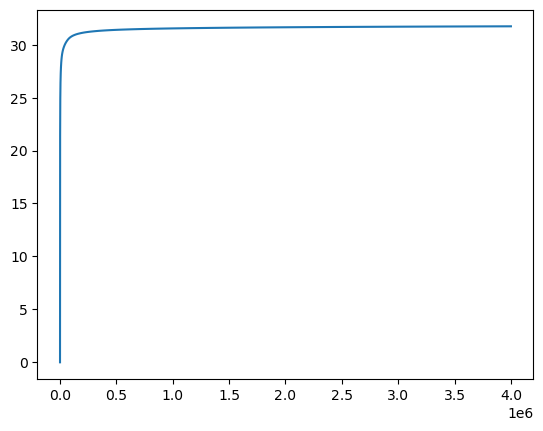

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000000006F263AF0>

In [155]:
start = floor(Int64, nMax/10)
start = 1
PyPlot.plot(start:nMax,resultNewVFA[4][start:nMax])

Not converged 

In [150]:
ve = resultNewVFA[1]
vn = resultNewVFA[2]
println(v([1,1,1,1,1],N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn))
println(v([3,3,3,3,3],N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn))

258.7352284949891
1935.3753331244063


In [151]:
vn

Dict{Any, Any} with 2 entries:
  0 => 212.581
  1 => 615.931

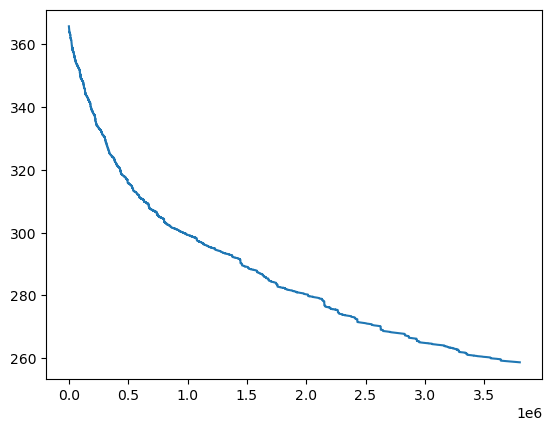

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000158183F70>

In [152]:
vs0Hist = resultNewVFA[5]
PyPlot.plot(vs0Hist[200000:nMax])

In [153]:
evalNMax = 1000000
g0 = resultNewVFA[3]
gs = gEvaluationNewVFA(N,alpha_d, alpha_r, beta, tau, c0, c1, r, evalNMax, ve, vn, g0; printProgress = false, modCounter = 100000)
gs[1]

32.88098930918824

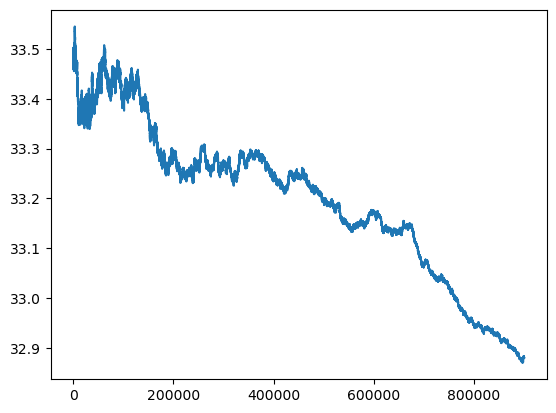

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000000006F2080D0>

In [154]:
PyPlot.plot(gs[2][100000:evalNMax])

## Constant Stepsize

In [163]:
nMax = 4000000
resultNewVFA_CStep = smarviNewVFA_ST(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, 0.01, 10.0, 0.1; stepsizeType = "constant", printProgress = true, modCounter = 1000000)
println("Complete")
println(resultNewVFA_CStep[3])

1000000
2000000
3000000
4000000
Complete
25.747221854745142


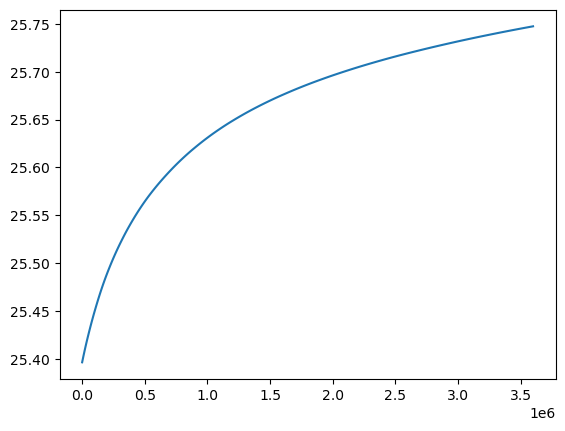

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000068129190>

In [170]:
start = floor(Int64, nMax/10)
#start = 1
PyPlot.plot(resultNewVFA_CStep[4][start:nMax])

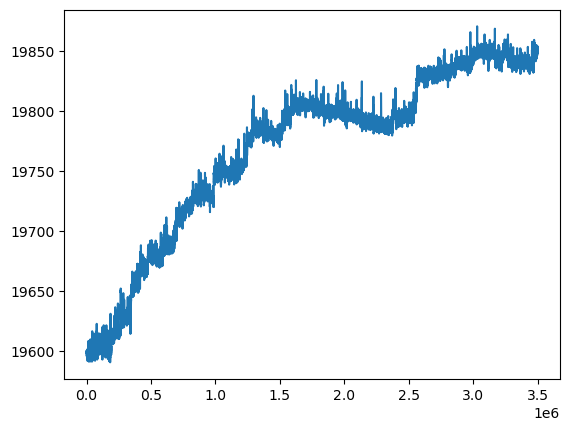

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000682271C0>

In [174]:
vs0Hist = resultNewVFA_CStep[5]
PyPlot.plot(vs0Hist[500000:nMax])

In [167]:
ve = resultNewVFA_CStep[1]
vn = resultNewVFA_CStep[2]
println(v([1,1,1,1,1],N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn))
println(v([3,3,3,3,3],N,alpha_d, alpha_r, beta, tau, c0, c1, r, ve, vn))

19850.907294940913
21072.281417339582


In [168]:
vn

Dict{Any, Any} with 2 entries:
  0 => 6062.88
  1 => 4401.15

In [171]:
evalNMax = 1000000
ve = resultNewVFA_CStep[1]
vn = resultNewVFA_CStep[2]
g0 = resultNewVFA_CStep[3]
gs = gEvaluationNewVFA(N,alpha_d, alpha_r, beta, tau, c0, c1, r, evalNMax, ve, vn, g0; printProgress = true, modCounter = 100000)
gs[1]

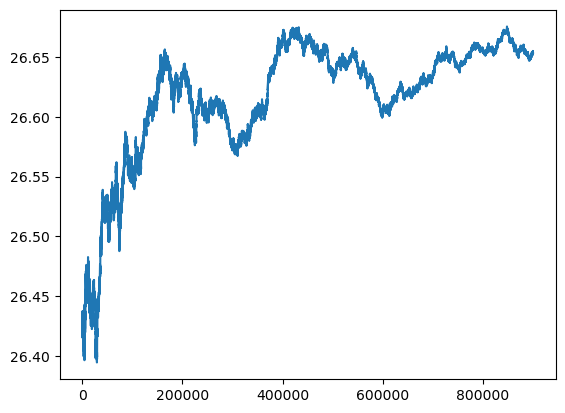

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000068145FD0>

In [172]:
start = floor(Int64, evalNMax/10)
PyPlot.plot(gs[2][start:evalNMax])